# Freeway

This is the first project for the MC935rA/MO436A - Reinforcement Learning course, taught by Prof. Esther Colombini.

In this project we propose to apply Reinforcement Learning methods to teach an agent how to play the Freeway Atari game.

**Group members:**
- Aline Gabriel de Almeida
- Dionisius Oliveira Mayr (229060)
- Leonardo de Oliveira Ramos (171941)
- Marianna de Pinho Severo (264960)
- Victor Jesús Sotelo Chico (265173)

## Freeway game

![Baseline 1](./img/Freeway_logo.png)

Freeway is a video game written by David Crane for the Atari 2600 and published by Activision [[1]](https://en.wikipedia.org/wiki/Freeway_(video_game)).

In the game, two players compete against each other trying to make their chickens cross the street, while evading the cars passing by.
There are three possible actions: staying still, moving forward or moving backward.
Each time a chicken collides with a car, it is forced back some spaces and takes a while until the chicken regains its control.

When a chicken is successfully guided across the freeway, it is awarded one point and moved to the initial space, where it will try to cross the street again.
The game offers multiple scenarios with different vehicles configurations (varying the type, frequency and speed of them) and plays for 2 minutes and 16 seconds.
During the 8 last seconds the scores will start blinking to indicate that the game is close to end.
Whoever has the most points after this, wins the game!

The image was extracted from the [manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf).

[1 - Wikipedia - Freeway](https://en.wikipedia.org/wiki/Freeway_(video_game))

# Environment

We will be using the [OpenAI Gym](https://gym.openai.com/) toolkit.
This toolkit uses the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment) to simulate the game through the [Stella](https://stella-emu.github.io/) emulator.

Although the game offers multiple scenarios, we are going to consider only the first one. Also, we will be controlling a *single chicken*, while we try to maximize its score.

In this configuration, there are ten lanes and each lane contains exactly one car (with a different speed and direction).
Whenever an action is chosen, it is repeated for $k$ frames, $k \in \{2, 3, 4\}$.

This means that our environment is **stochastic** and it is also **episodic**, with its terminal state being reached whenever 2 minutes and 16 seconds have passed.

Our base state representation is given by the RAM of the Atari 2600 (more on this latter).

You can find more information regarding the environment used at [Freeway-ram-v0](https://gym.openai.com/envs/Freeway-ram-v0/).

# Setup

Install the dependencies:
```sh
pip install -r requirements.txt
```

# Useful Resources

Here you can find a list of useful links and materials that were used during this project.

* [Freeway-ram-v0 from OpenAI Gym](https://gym.openai.com/envs/Freeway-ram-v0/)
* [Manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf)
* [Freeway Disassembly](http://www.bjars.com/disassemblies.html)
* [Atari Ram Annotations](https://github.com/mila-iqia/atari-representation-learning/blob/master/atariari/benchmark/ram_annotations.py)
* [Freeway Benchmarks](https://paperswithcode.com/sota/atari-games-on-atari-2600-freeway)

# Imports

In [1]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [2]:
%matplotlib inline
import statistics
from collections import defaultdict
from functools import lru_cache
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer
import src.gif as gif

In [3]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [4]:
def read_int_array_from_file(fn: str):
    with open(f"./experiments/{fn}") as f:
        return [int(x) for x in f.read().splitlines()]

# Action space

As we said above, the agent in this game has three possible actions at each frame, each represented by an integer:

* 0: Stay
* 1: Move forward
* 2: Move backward

In theory, a perfect chicken wouldn't ever need to move backward, since it is possible to know if moving forward would lead you into a collision (in the immediate frame or in the future frames).

In our project we will be experimenting with agents using only two possible actions (staying and moving forward) and also agents using all the three possible actions.

# Baseline

## State of the art benchmarks

The image bellow (extracted from https://paperswithcode.com/sota/atari-games-on-atari-2600-freeway) shows the evolution of the scores over time using different techniques.

Today, the state of the art approaches are making 34.0 points, using Deep Reinforcement Learning methods.

However, since we are using tabular methods, we don't think it will be possible to beat this benchmark.
Instead, we will be looking at a different, simpler baseline.

![Benchmarks](./img/state_of_art_scores.png)

## Simple baseline agent

As a simple baseline, we are using an agent that always moves **up**, regardless of the rewards received or the current state.

In [5]:
env, initial_state = environment.get_env()

In [6]:
agent = agents.Baseline()

In [7]:
total_rewards = []
n_runs = 10

In [8]:
%%time
for i in range(n_runs):
    render = i % 10 == 0

    game_over = False
    state = env.reset()
    action = agent.act(state)

    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.01)
            env.render()

        ob, reward, game_over, _ = env.step(action)

        total_reward += reward
        action = agent.act(state)  # Next action

    total_rewards.append(total_reward)

CPU times: user 21.5 s, sys: 544 ms, total: 22.1 s
Wall time: 50 s


In [9]:
total_rewards

[23.0, 21.0, 23.0, 21.0, 21.0, 21.0, 23.0, 21.0, 23.0, 21.0]

In [10]:
baseline_mean_score = np.mean(total_rewards)
baseline_mean_score

21.8

As we can see, this agent usually scores 21 or 23 points (as shown in the images bellow). It depends on the the values of $k$ sampled, and on average it scores about 21.8 points per run.

![Baseline 1](./img/baseline_1.png)
![Baseline 2](./img/baseline_2.png)

# State Representation

Since the tabular methods we are going to use work with some representation of the actual environment state, we will need to understand it better in order to effectively approach this problem.

## Atari 2600

Before talking about the state representation, it is important to understand how the Atari 2600 works.

Atari 2600 is a video game released in 1977 by the American Atari, Inc.
Its **8-bit** microprocessor was of the MOS **6502** family and it had **128 bytes** of RAM.

And these 128 bytes are what really matters here.

---

Recall that Gym gives us the RAM memory of the Atari as the state representation.
In other words, it gives us an 128-element `np.array`, where each element of the array is an `uint8` (*integer values ranging from 0 to 255*).

That said, we have (in theory) $256^{128} \approx 1.8 \cdot 10^{308}$ possible game states!

This is *far* from being manageable, and thus we need to come up with a different approch to represent our state if we want our algorithms to converge.

One might argue that the RAM state is *sparse* and although that is true, it is still not sparse enough to apply tabular methods.

## Selecting useful bytes

We will try to select only the bytes that are useful to deal with our problem.

To do so, we will be looking at a [fan made disassembly](http://www.bjars.com/disassemblies.html) by Glenn Saunders.

From the 6502 assembly we can see the variables locations in the memory, their size and count the amount of bytes since the initial offset to determine which byte represents what.

Simplifying it a bit, we would end up with a list of candidate bytes for our state representation like this:

|Description| Bytes |
|----|----|
| Chicken Y | 14 |
| Chicken Lane Collide | 16 |
| Chicken Collision flag | 18 |
| Car X Direction | 22 |
| Z Car Patterns | 23, 24, 25, 26, 27, 28, 29, 30, 31, 32 |
| Car Motion Timmers | 33, 34, 35, 36, 37, 38, 39, 40, 41, 42 |
| Car Motions | 43, 44, 45, 46, 47, 48, 49, 50, 51, 52 |
| Car Shape Ptr | 87, 88 |
| Chicken Shape Ptr | 89, 90 |
| Chicken Sounds | 106, 107 |
| Car X Coords | 108, 109, 110, 111, 112, 113, 114, 115, 116, 117 |

After observing them, we were able to filter bytes that wouldn't be useful for us (like auxiliary variables used during function calls, e.g. `Car Motion Timmers`, `Chicken Sounds`) and bytes that contain constant values, like `Car X Direction` and`Car Motions`.

The final list of bytes being used is given here:

|Description| Bytes |
|----|----|
| Chicken Y | 14 |
| Chicken Lane Collide | 16 |
| Car X Coords | 108, 109, 110, 111, 112, 113, 114, 115, 116, 117 |

In [11]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collided
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

Thus, we went from using 128 bytes to only 12, with $256^{12} \approx 7.9 \cdot 10^{28}$ theoritical possible states.

But this is still a lot.
We need to reduce it even more, and that is exactly what the function `reduce_state` bellow does:

In [12]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

We are using 4 strategies to reduce our state.

* The `byte[16]` represents the lane where a collision happened. Instead of using it like this, we will make it binary, 1 being a collision (on any lane) and 0 otherwise.
* The `byte[14]` represents the y-position of the chicken (from 0 to ~170). We will be losing a bit of precision here in order to reduce the state space, dividing (truncating the fractional part) the `byte[14]` by 3.
* The `bytes[108:118]` are used as the cars x-position. If they are far from the chicken (the chicken x-position is fixed at ~49), we won't care about them, setting it as 0. If they are near the chicken (between x-20 and x-80), we will represent them again dividing by 3. The idea here is that the cars that are near the chicken contain more valuable information than the cars far from it. 

Now we have $2 \cdot 57 \cdot 21^{10} \approx 1.9 \cdot 10^{15}$ theoritical possible states.

This might seen like it is still too much, but as we will soon see, empirically this number is far smaller.

The biggest factor of the $10^{15}$ states is due to the cars x-positions.
But recall that each car has a constant speed (which can be different from the other cars). Because of it, their positions are periodical, meaning that they don't use the entire range of possible values in their byte.

For instance: a car with speed 4 will *never* be at the x-coordinate 3, nor will a car with speed 2.

# Reward Policy

In the base environment we are awarded on point each time we successfully cross the freeway.

However, it stands to reason experimenting with other reward strategies, like penalizing collisions or standing still and also changing the numerical value of these quantities.

The method bellow allows us to experiment multiple reward policies.

We defined some conditions were the agent get a reward: 
- `REWARD_IF_CROSS`: If the chicken cross the 10 lanes; this is our fundamental goal and should be encouraged;
- `REWARD_IF_COLLISION`: If the chicken collides with a car; as the collisions can delay the chicken to cross the lanes, it can be discouraged;
- Each one of the agent's three actions can be rewarded according to how much they can help the chicken to cross all the lanes and doing so we can hopefully accelerate the conversion of the algorithms. The `REWARD_IF_STILL` is the reward given if the chicken doesn't  move up, and *can* be discouraged in some cases.

In [13]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

# Hyper Parameters

In [14]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5
LAMBD = 0.2

reward_policy.REWARD_IF_CROSS = 1
reward_policy.REWARD_IF_COLLISION = 0
reward_policy.REWARD_IF_STILL = 0

# Methodology

Since it takes a lot of time to train the models, we won't train them all in this report.
Instead, we will be load the results of our simulations and specifying the parameters used to obtain those results.
Of course, it is possible to reproduce our results simply by running the algorithms here using the same hyper parameters as specified.

You can find inside `./experiments/` the collection of results that we generated, and inside `./serialized_models/` one can find some serialized models.
We don't advise trying to load the serialized models in machines different from the machine where it was generated beucase of compatibility issues.

Whenever possible, we will be adding plots comparing different approaches and parameters, as well as adding gifs in this notebook so that we can visualize the development of the agent and unique strategies that they learned.

Also, we focused a lot of our experiments on Q-Learning, since it was showing the most promissor results.
Monte Carlo methods didn't really work out, and SARSA($\lambda$) methods took way too much time to run (roughly 12 hours per 2k iterations!).
Since QLearning and SARSA aren't really that different, we applied most of the knowledge we acquired from the QLearning experiments on SARSA, varying only its unique parameter, $\lambda$, in steps of 0.2.

Also, it is worth mentioning that we left the code used by each agent inside `./src/agents.py` and provided a model of implementing the environment along the notebook, with the `n_runs` parameter (that controls the number of episodes used in to train the algorithm) set to `1`.

---

# Q-Learning

The Q-learning algorithm receives the $\gamma$ and the $N0$ parameters.  

$\gamma$ is the discount factor; This parameters determines the importance of future rewards. A value of 0 makes the agent short-sighned by only considering current rewards, while a factor approaching 1 will make it strive for a long term reward.  

The $N0$ parameter is used to define the agent's exploration rate $\epsilon$, where $\epsilon = N0/(N0+N_{sa})$ and $N_{sa}$ is the number of visits in the state $s$ where the action $a$ was taken.

In the algorithm, the action-value function is initialized to zero. Then, at each time $t$ the agent selects an action $a_t$, observes a reward $r_t$, enters a new state $s_{s+1}$, and $Q$ is updated:

$Q_{new}(s_t, a_t) :=  Q(s_t, a_t)+\alpha (r_t + \gamma.max_aQ(s_{t+1},a)-Q(s_t, a_t))$

The learning rate $\alpha$ is defined as $\alpha = 1/N_{sa}$, where $N_{sa}$ is the number of times that the specific state-action pair has already occured.

In [15]:
env, initial_state = environment.get_env()

In [16]:
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [17]:
scores = []
total_rewards = []

In [18]:
%%time
n_runs = 1

for i in range(n_runs):
    render = i % 200 == 201

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
    
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Run [   0] - Total reward:   12.00 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s


## Serialize the model

In [19]:
# Optional! You can use this code to serialize models!
# exp = serializer.Experiment(agent, scores, total_rewards, reduce_state, reward_policy)
# exp.save_experiment('QL_EXPERIMENT')

## Experiments

### Influence of the number of actions

Here we will compare the impact that the number of possible actions (3 vs 2) has on our score.

To do so, we will run the QLearn algorithm twice, with 3 actions and with 2 actions, and then compare the scores obtained. The complete set of parameters used is shown bellow:

Parameters used:

| Parameter | A2 | A3 |
|------|----|----|
| `GAMMA` | 0.99 | 0.99 |
| `AVAILABLE_ACTIONS` | 2 | 3 |
| `N0` | 2.5 | 2.5 |
| `CROSS` | 1 | 1 |
| `COLLISION` | 0 | 0 |
| `STILL` | 0 | 0 |

In [20]:
scores_2act = read_int_array_from_file("./QL/QL_scores_2act.txt")
total_rewards_2act = read_int_array_from_file("./QL/QL_total_rewards_2act.txt")
scores_3act = read_int_array_from_file("./QL/QL_scores_3act.txt")
total_rewards_3act = read_int_array_from_file("./QL/QL_total_rewards_3act.txt")

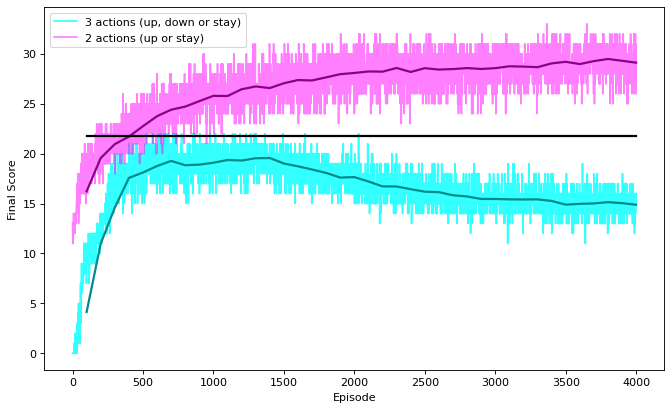

In [21]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_2scores(scores_3act[:4000], scores_2act[:4000], "3 actions (up, down or stay)", "2 actions (up or stay)")
aux_plots.moving_average(scores_2act[:4000], ax, label='2 actions moving avg', color='darkmagenta')
aux_plots.moving_average(scores_3act[:4000], ax, label='3 actions moving avg', color='darkcyan')
aux_plots.moving_average(baseline[:4000], ax, label='Baseline', color='black')

From the graph above, we can see that when using only two actions the agent learns faster than with three actions, thus leading to better results in less iterations.

As we said before, this is expected and we will now be focusing only on testing with two actions.

Since we are using the default reward policy, the reward graph is exactly the same as the score, and thus we won't be showing it here.

It might seem strange at first that using three actions is presenting a decrease in the performance, and bellow we  show various gifs comparing their behavior.

| #Episodes | 0 | 500 | 1000 | 1500 | 2000 |
|------|----|---|---|---|---|
| Three actions | ![QL-R3_0](./gif/QL_base_3_actions_i0.gif) | ![QL-R3_500](./gif/QL_base_3_actions_i500.gif) | ![QL-R3_1000](./gif/QL_base_3_actions_i1000.gif) | ![QL-R3_1500](./gif/QL_base_3_actions_i1500.gif) | ![QL-R3_2000](./gif/QL_base_3_actions_i2000.gif) |

We can see that at the beginning (0 episodes) and also after 1000 episodes, the chicken tries a lot to go back and forth, losing a lot of time in doing so.
We think that this happens because it is much more likely for us to reach different states, even though they aren't particularly good.
And when we arrive at a new state, we have to explore it some times, until we start to really exploit, leading to poor results.
Also, sometimes the 500 and 1000-chicken seems to avoid some cars, but since it doesn't happen so often (it collides a lot as well), we can't really say that it is learning to avoid collisions.

Bellow you can find two gifs comparing the different behaviors of these two agents after 4k episodes.

| #Episodes | Two actions | Three actions |
|------|----|---|
| 4000 | ![QL-A2](./gif/QL_scores_2act.gif) | ![QL-A3](./gif/QL_base_3_actions.gif) | 

Notice that the three actions chicken spends some time going back and forth, instead of trying to cross the lane, and most of the time it does this for no aparent reason.
While the two actions chicken is able to score 21 points, the three actions chicken scores only 16.

### Influence of the reward values

In order to investigate the influence of the reward values in the agent behavior, we ran the algorithm using three different sets of reward values.

* **R1:** Positive rewards for crossing: it offered a sparse reward to the agent: +1 if the chicken cross all the lanes.  
* **R2:** Positive rewards for crossing and negative reward for colliding: it given +1 for crossing all the lanes and -1 if the chicken collide. Thus, we expect the agent to be encouraged to cross the lanes (positive reward) and to avoid collisions (negative reward).  
* **R3:** Huge positive reward for crossing and negative reward for colliding or staying in the same position: it increased the reward for crossing all the lanes to +500 and give -10 when the chicken collide. It also gives a negative reward of -1 when the agent decide to **still**. Thus we expect the chicken to cross all the lanes faster and increase the final score.

| Parameter | R1 | R2 | R3 |
|------|----|----|----|
| `GAMMA` | 0.99 | 0.99 | 0.99 |
| `AVAILABLE_ACTIONS` | 2 | 2 | 2 |
| `N0` | 2.5 | 2.5 | 2.5 |
| `CROSS` | 1 | 1 | 500 |
| `COLLISION` | 0 | -1 | -10 |
| `STILL` | 0 | 0 | -1 |

In [22]:
scores_2act_R1 = read_int_array_from_file('./QL/QL_scores_2act_R1.txt')
scores_2act_R2 = read_int_array_from_file('./QL/QL_scores_2act_R2.txt')
scores_2act_R3 = read_int_array_from_file('./QL/QL_scores_2act_R3.txt')

total_rewards_2act_R1 = read_int_array_from_file('./QL/QL_total_rewards_2act_R1.txt')
total_rewards_2act_R2 = read_int_array_from_file('./QL/QL_total_rewards_2act_R2.txt')
total_rewards_2act_R3 = read_int_array_from_file('./QL/QL_total_rewards_2act_R3.txt')

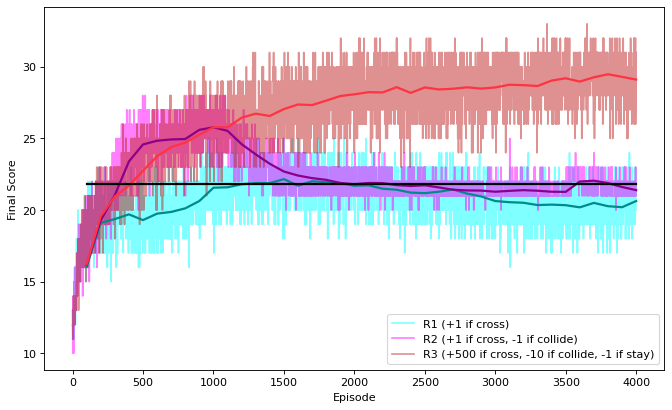

In [23]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_R1[:4000], scores_2act_R2[:4000], scores_2act_R3[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)", "R3 (+500 if cross, -10 if collide, -1 if stay)")

aux_plots.moving_average(scores_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='darkcyan')
aux_plots.moving_average(scores_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='darkmagenta')
aux_plots.moving_average(scores_2act_R3[:4000], ax, label="R3 (+500 if cross, -10 if collide, -1 if stay)", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

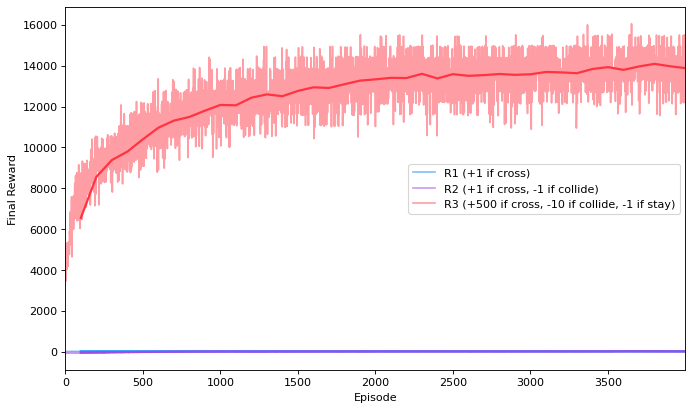

In [24]:
ax = aux_plots.plot_3rewards(total_rewards_2act_R1[:4000], total_rewards_2act_R2[:4000], total_rewards_2act_R3[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)", "R3 (+500 if cross, -10 if collide, -1 if stay)")

aux_plots.moving_average(total_rewards_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='#1F8FFF')
aux_plots.moving_average(total_rewards_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='#9C4BE7')
aux_plots.moving_average(total_rewards_2act_R3[:4000], ax, label="R3 (+500 if cross, -10 if collide, -1 if stay)", color='#FF3341')

Since the scales of the rewards vary a lot, we are separating R3 from R1 and R2, so we can compare than easily.

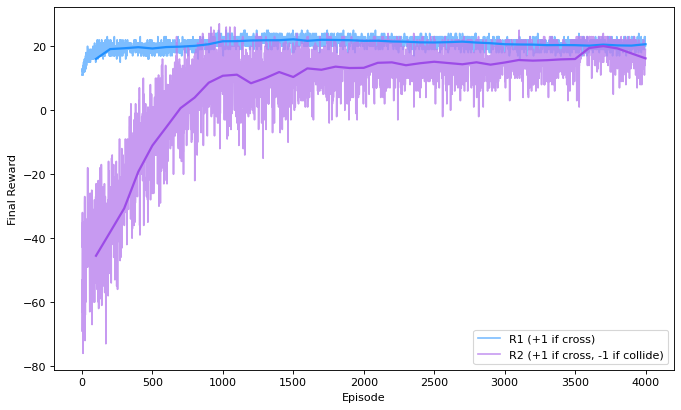

In [25]:
ax = aux_plots.plot_2rewards(total_rewards_2act_R1[:4000], total_rewards_2act_R2[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)")

aux_plots.moving_average(total_rewards_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='#1F8FFF')
aux_plots.moving_average(total_rewards_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='#9C4BE7')

Recall that R1 is the default reward policy of our system, where the chicken receives 1 reward each time it crosses the freeway, and thus it is the same as the score.

From these graphs we can see that for about 250 iterations the agents are scoring basically the same amount of points, but a few episodes latter, its behaviour change completely.
R2 starts to show a very good performance for a while, but as it explores more and tries to maximize its reward, it starts getting more "coward", avoiding colliding with cars at all costs, even if it means staying still.
The R2 agent prefers not to take risks, since one collision "takes" as much reward as it would get with a successful cross.
That is why after 1000 episodes its performance starts to degrade a lot.
This is the point where the agent starts to learn that in order to maximize its reward, it is better to stay still than to try to cross.
Thus, even though the reward obtained is still good, the score is not.

This behavior led us to the R3 approach, where we give a higher reward to crossing (500), while we still penalize collisions (-10) and also penalize staying still (-1).
By doing so, we incentivate the agent to cross while discouraging it to collide or staying still.
We give a higher penalty to collisions instead of staying still because the agent can avoid a collision by not moving.
After a thound episodes, we can already see that this is the solution that performs better among these three, **scoring close to 30 points** in 4000 episodes!

Notice that they haven't fully converged yet.
However, the gain that we obtain from now on is marginal, compared to the time it takes for it to run.

### Influence of the discount factor

The discount factor $\gamma$ determines how much the agent cares about rewards in the distant future relative to those in the immediate future.  

If $\gamma$=0, the agent will be completelly myopic and only learn about actions that produce an immediate reward.If $\gamma$=1, the agent will evaluate each of its actions based on the sum of total of all futures rewards.

We used a $\gamma$ value of 0.99 in order to make our agent care about distant future and we also decreased this value to 0.90 and 0.75 to see how they can impact the agent behavior. 

Thus, we will be experimenting with 3 different parameters set:

| Parameter | G1 | G2 | G3 |
|------|----|----|----|
| `GAMMA` | 0.99 | 0.90 | 0.75 |
| `AVAILABLE_ACTIONS` | 2 | 2 | 2 |
| `N0` | 2.5 | 2.5 | 2.5 |
| `CROSS` | 500 | 500 | 500 |
| `COLLISION` | -10 | -10 | -10 |
| `STILL` | -1 | -1 | -1 |

In [26]:
scores_2act_gamma_0p99 = read_int_array_from_file('./QL/QL_scores_2act_R3.txt')
scores_2act_gamma_0p9 = read_int_array_from_file('./QL/QL_scores_2act_gamma_0p9.txt')
scores_2act_gamma_0p75 = read_int_array_from_file('./QL/QL_scores_2act_gamma_0p75.txt')

total_rewards_2act_gamma_0p99 = read_int_array_from_file('./QL/QL_total_rewards_2act_R3.txt')
total_rewards_2act_gamma_0p9 = read_int_array_from_file('./QL/QL_total_rewards_2act_gamma_0p9.txt')
total_rewards_2act_gamma_0p75 = read_int_array_from_file('./QL/QL_total_rewards_2act_gamma_0p75.txt')

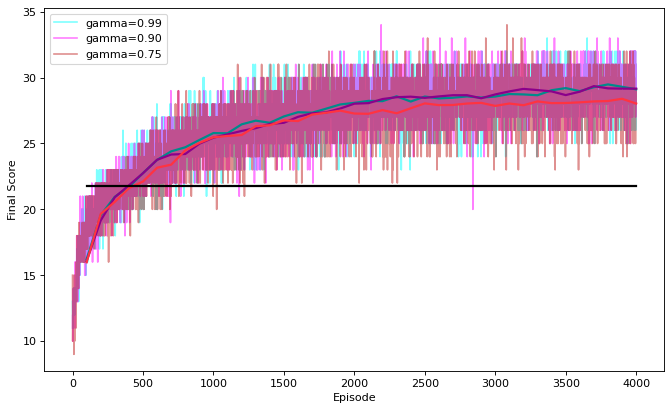

In [27]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_gamma_0p99[:4000], scores_2act_gamma_0p9[:4000], scores_2act_gamma_0p75[:4000], "gamma=0.99", "gamma=0.90", "gamma=0.75")

aux_plots.moving_average(scores_2act_gamma_0p99[:4000], ax, label="gamma=0.99", color='darkcyan')
aux_plots.moving_average(scores_2act_gamma_0p9[:4000], ax, label="gamma=0.90", color='darkmagenta')
aux_plots.moving_average(scores_2act_gamma_0p75[:4000], ax, label="gamma=0.75", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

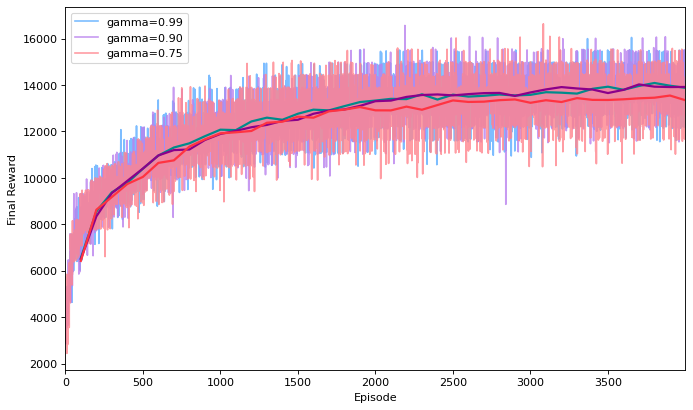

In [28]:
ax = aux_plots.plot_3rewards(total_rewards_2act_gamma_0p99[:4000], total_rewards_2act_gamma_0p9[:4000], total_rewards_2act_gamma_0p75[:4000], "gamma=0.99", "gamma=0.90", "gamma=0.75")

aux_plots.moving_average(total_rewards_2act_gamma_0p99[:4000], ax, label="gamma=0.99", color='darkcyan')
aux_plots.moving_average(total_rewards_2act_gamma_0p9[:4000], ax, label="gamma=0.90", color='darkmagenta')
aux_plots.moving_average(total_rewards_2act_gamma_0p75[:4000], ax, label="gamma=0.75", color='#FF3341')

From the plots above we can see that $\gamma = 0.75$ led to poor results, but $\gamma = 0.9$ and $\gamma = 0.99$ seems to be equivalent.
An explanation is that when we make our agent short-sighted, it doesn't try to cross all the lanes and receive that huge reward we are offering as much as the far-sighted agents try.

That being said, we will be focusing on the $\gamma = 0.99$, arbitrarily.
We could be using the $0.9$ too, since it appears to have the same performance.

### Influence of the $N0$ parameter that is used to define the agent's exploration rate $\epsilon$

The exploration rate is the probability that our agent will explore the environment rather than exploit it.  
The $N0$ parameter is used to define the agent's exploration rate $\epsilon$ , where  $\epsilon = N0/(N0+N_{sa})$ and $N_{sa}$ is the number of times that state $s$ has been visited and taken the action $a$.

We used a very small value of $N0$ (0.001) so we can see how well the agent performs if this constant $N0$ had almost no impact in the exploration rate done and we also used $N0$ = 2.5 and $N0$ = 5.0 so we can see how the exploration rate impact the agent behavior.

All in all, these are the parameters that we are going to use to execute this experiment.

| Parameter | N1 | N2 | N3 |
|------|----|----|----|
| `GAMMA` | 0.99 | 0.99 | 0.99 |
| `AVAILABLE_ACTIONS` | 2 | 2 | 2 |
| `N0` | 0.001 | 2.5 | 5.0 |
| `CROSS` | 500 | 500 | 500 |
| `COLLISION` | -10 | -10 | -10 |
| `STILL` | -1 | -1 | -1 |

In [29]:
scores_2act_N0_0 = read_int_array_from_file('./QL/QL_scores_2act_N0_0.txt')
scores_2act_N0_25 = read_int_array_from_file('./QL/QL_scores_2act_R3.txt')
scores_2act_N0_5 = read_int_array_from_file('./QL/QL_scores_2act_N0_5.txt')

total_rewards_2act_N0_0 = read_int_array_from_file('./QL/QL_total_rewards_2act_N0_0.txt')
total_rewards_2act_N0_25 = read_int_array_from_file('./QL/QL_total_rewards_2act_R3.txt')
total_rewards_2act_N0_5 = read_int_array_from_file('./QL/QL_total_rewards_2act_N0_5.txt')

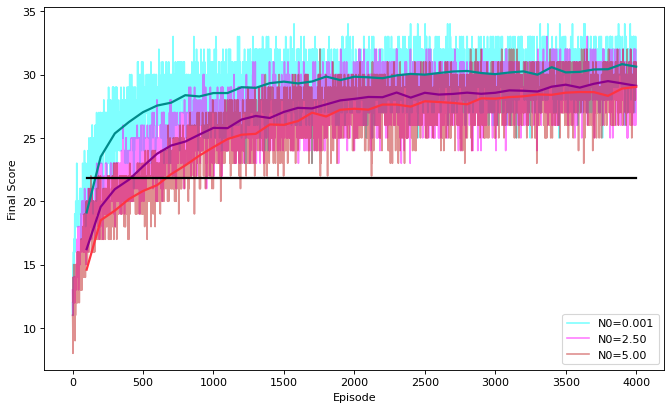

In [30]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_N0_0[:4000], scores_2act_N0_25[:4000], scores_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

aux_plots.moving_average(scores_2act_N0_0[:4000], ax, label="N0=0.001", color='darkcyan')
aux_plots.moving_average(scores_2act_N0_25[:4000], ax, label="N0=2.50", color='darkmagenta')
aux_plots.moving_average(scores_2act_N0_5[:4000], ax, label="N0=5.00", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

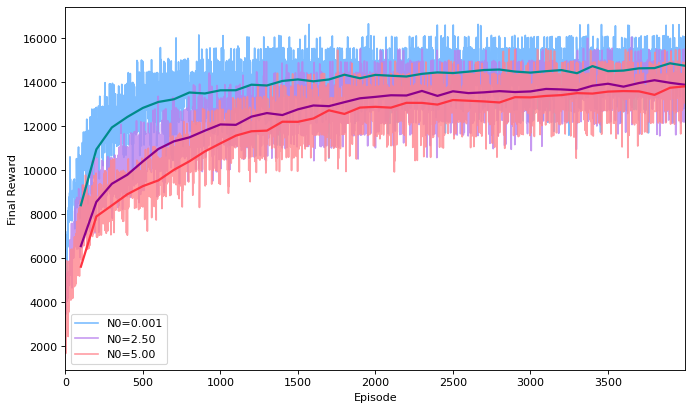

In [31]:
ax = aux_plots.plot_3rewards(total_rewards_2act_N0_0[:4000], total_rewards_2act_N0_25[:4000], total_rewards_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

aux_plots.moving_average(total_rewards_2act_N0_0[:4000], ax, label="N0=0.001", color='darkcyan')
aux_plots.moving_average(total_rewards_2act_N0_25[:4000], ax, label="N0=2.50", color='darkmagenta')
aux_plots.moving_average(total_rewards_2act_N0_5[:4000], ax, label="N0=5.00", color='#FF3341')

The exploration rate is the probability that our agent will explore the environment rather than exploit it.  

As we can see from the results show in the plots above, the lower is the $N0$ value, the better is the performance of the agent.
Although this migth seem counterintuitive at first, in fact, it stands to reason.
When we explore more (higher $N0$), we exploit less, leading to worst results in the beginning.
From the graphs above, we can see that all three lines are looking up, still increasing their values, and the gap between them is closing.
We expect to achive better results with higher $N0$s, but it would take too much time for it to happen (we even tested some of them overnight and it still wasn't enough).

Based on our reward function, it is fairly simple to detect which action should be taken in most of the states.
We want to move up always, unless it is leading to a collision.
Thus, frequently it is easy to detect the best action, and for most of the states we don't need to explore a lot to find it.

## Visualizations and conclusions

Bellow you can find some gifs showing how the agents behave.
You will find two different parameters, at different stages of training.
The bottom one is the agent that seems to perform the best.

We can see that the 4000-Champion **learned how to evade cars**, although still being really agressive in trying to cross the lanes! It is clear that the chicken goes as far as it can before hitting a car, and them suddenly stops until the car passes by, and starts running again (optimal behavior!).

On the other hand, we also discovered a *Coward* chicken.
Looking at the 4000-step Coward chicken, we can see that it became more afraid of hitting other cars because of the reward policy used (-1 per collision and +1 per successful crossing).
You can observe that sometimes it stops "far" from the cars, and only move after it has passed.

| #Episodes | 0 | 500 | 1000 | 2000 | 4000 |
|------|----|---|---|---|---|
| Coward - R2 N2.5 G0.99 | ![QL-R2_0](./gif/QL-R2_0.gif) | ![QL-R2_500](./gif/QL-R2_500.gif) | ![QL-R2_1000](./gif/QL-R2_1000.gif) | ![QL-R2_2000](./gif/QL-R2_2000.gif) | ![QL-R2_4000](./gif/QL-R2_4000.gif) |
| Champion - R3 N2.5 G0.99 | ![QL-R3_0](./gif/QL-R3_0.gif) | ![QL-R3_500](./gif/QL-R3_500.gif) | ![QL-R3_1000](./gif/QL-R3_1000.gif) | ![QL-R3_2000](./gif/QL-R3_2000.gif) | ![QL-R3_4000](./gif/QL-R3_4000.gif) |

---

# Monte Carlo Control

The Monte Carlo algorithm receives the $\gamma$ and the $N0$ parameters.

$\gamma$ is the discount factor; This parameters determines the importance of future rewards. A value of 0 makes the agent short-sighned by only considering current rewards, while a factor approaching 1 will make it strive for a long term reward.  

The $N0$ parameter is used to define the agent's exploration rate $\epsilon$, where $\epsilon = N0/(N0+N_{sa})$ and $N_{sa}$ is the number of visits in the state $s$ where the action $a$ was taken.

In the algorithm, the value function is initialized to zero.

In [32]:
env, initial_state = environment.get_env()

In [33]:
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [34]:
def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env
                                   , reduce_state=reduce_state
                                   , reward_policy=reward_policy
                                   , agent=agent
                                   , RAM_mask=RAM_mask
                                   , render=render)
    return agent.update_policy(epi)

In [35]:
scores = []
total_rewards = []

In [36]:
%%time
n_runs = 1

for i in range(n_runs):
    render = i % 201 == 200

    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Run [   0] - Total reward:   12.00 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
CPU times: user 2.05 s, sys: 3.44 ms, total: 2.05 s
Wall time: 2.05 s


## Experiments

### Influence of the number of actions 

As the goal of the game is to cross all the lanes, we propose that it would be enought if the chicken use just the two actions move **up** or **stay** and never move **down**.
<br>
As we did for the Q-learning agent, in order to test our hypothesis also for Monte Carlo control, we ran the agent using 3 and 2 actions.  

In [37]:
scores_2act = read_int_array_from_file("./MC/MC_scores_2act.txt")
scores_3act = read_int_array_from_file("./MC/MC_scores_3act.txt")

total_rewards_2act = read_int_array_from_file("./MC/MC_total_rewards_2act.txt")
total_rewards_3act = read_int_array_from_file("./MC/MC_total_rewards_3act.txt")

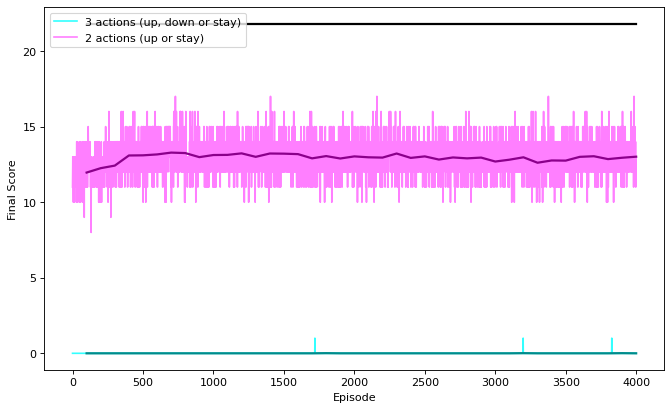

In [38]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_2scores(scores_3act[:4000], scores_2act[:4000], "3 actions (up, down or stay)", "2 actions (up or stay)")

aux_plots.moving_average(scores_2act[:4000], ax, label='2 actions moving avg', color='darkmagenta')
aux_plots.moving_average(scores_3act[:4000], ax, label='3 actions moving avg', color='darkcyan')
aux_plots.moving_average(baseline[:4000], ax, label='Baseline', color='black')

### Influence of the reward values

As we did for the Q-learning agent, in order to investigate the influence of the reward values in the agent behavior also for Monte Carlo control, we ran the algorithm using three different set of reward values.

**R1:** Positive rewards for crossing: it offered a sparse reward to the agent: +1 if the chicken cross all the lanes.

**R2:** Positive rewards for crossing and negative reward for colliding: it given +1 for crossing all the lanes and -1 if the chicken collide. Thus, we expect the agent to be encouraged to cross the lanes (positive reward) and to avoid collisions (negative reward).

**R3:** Huge positive reward for crossing and negative reward for colliding or staying in the same position: it increased the reward for crossing all the lanes to +500 and give -10 when the chicken collide. It also gives a negative reward of -1 when the agent decide to still. Thus we expect the chicken to be incentivate to cross the lanes more rapidilly and increase the score.

In [39]:
scores_2act_R1 = read_int_array_from_file('MC/MC_scores_2act_R1.txt')
scores_2act_R2 = read_int_array_from_file('MC/MC_scores_2act_R2.txt')
scores_2act_R3 = read_int_array_from_file('MC/MC_scores_2act_R3.txt')

total_rewards_2act_R1 = read_int_array_from_file('MC/MC_total_rewards_2act_R1.txt')
total_rewards_2act_R2 = read_int_array_from_file('MC/MC_total_rewards_2act_R2.txt')
total_rewards_2act_R3 = read_int_array_from_file('MC/MC_total_rewards_2act_R3.txt')

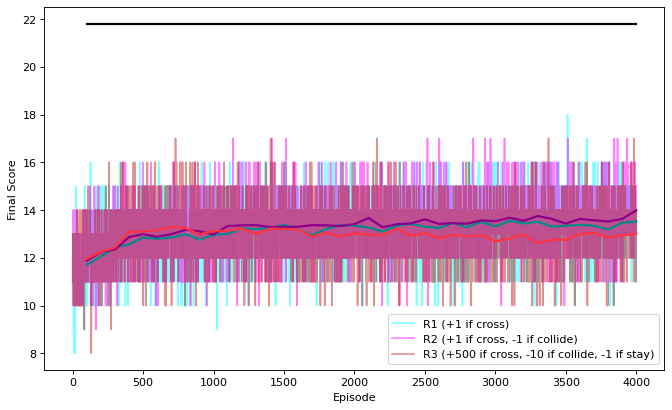

In [40]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_R1[:4000], scores_2act_R2[:4000], scores_2act_R3[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)", "R3 (+500 if cross, -10 if collide, -1 if stay)")

aux_plots.moving_average(scores_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='darkcyan')
aux_plots.moving_average(scores_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='darkmagenta')
aux_plots.moving_average(scores_2act_R3[:4000], ax, label="R3 (+500 if cross, -10 if collide, -1 if stay)", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

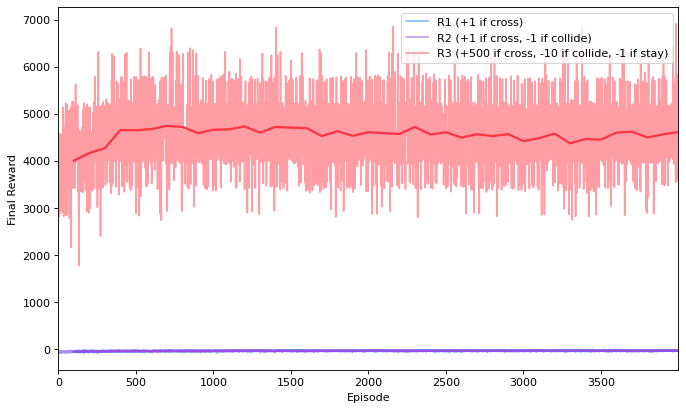

In [41]:
ax = aux_plots.plot_3rewards(total_rewards_2act_R1[:4000], total_rewards_2act_R2[:4000], total_rewards_2act_R3[:4000], "R1 (+1 if cross)", "R2 (+1 if cross, -1 if collide)", "R3 (+500 if cross, -10 if collide, -1 if stay)")

aux_plots.moving_average(total_rewards_2act_R1[:4000], ax, label="R1 (+1 if cross)", color='#1F8FFF')
aux_plots.moving_average(total_rewards_2act_R2[:4000], ax, label="R2 (+1 if cross, -1 if collide)", color='#9C4BE7')
aux_plots.moving_average(total_rewards_2act_R3[:4000], ax, label="R3 (+500 if cross, -10 if collide, -1 if stay)", color='#FF3341')

### Influence of the discount factor

The discount factor $\gamma$ determines how much the agent cares about rewards in the distant future relative to those in the immediate future.  

If $\gamma$=0, the agent will be completelly myopic and only learn about actions that produce an immediate reward.If $\gamma$=1, the agent will evaluate each of its actions based on the sum of total of all futures rewards.

We used a $\gamma$ value of 0.99 in order to make our agent care about distant future and we also decreased this value to 0.90 and 0.75 to see how they can impact the agent behavior. 

Thus, we will be experimenting with 3 different parameters set:

| Parameter | G1 | G2 | G3 |
|------|----|----|----|
| `GAMMA` | 0.99 | 0.90 | 0.75 |
| `AVAILABLE_ACTIONS` | 2 | 2 | 2 |
| `N0` | 2.5 | 2.5 | 2.5 |
| `CROSS` | 500 | 500 | 500 |
| `COLLISION` | -10 | -10 | -10 |
| `STILL` | -1 | -1 | -1 |

In [43]:
scores_2act_gamma_0p99 = read_int_array_from_file('./MC/MC_scores_2act_R3.txt')
scores_2act_gamma_0p9 = read_int_array_from_file('./MC/MC_scores_2act_gamma_0p9.txt')
scores_2act_gamma_0p75 = read_int_array_from_file('./MC/MC_scores_2act_gamma_0p75.txt')

total_rewards_2act_gamma_0p99 = read_int_array_from_file('./MC/MC_total_rewards_2act_R3.txt')
total_rewards_2act_gamma_0p9 = read_int_array_from_file('./MC/MC_total_rewards_2act_gamma_0p9.txt')
total_rewards_2act_gamma_0p75 = read_int_array_from_file('./MC/MC_total_rewards_2act_gamma_0p75.txt')

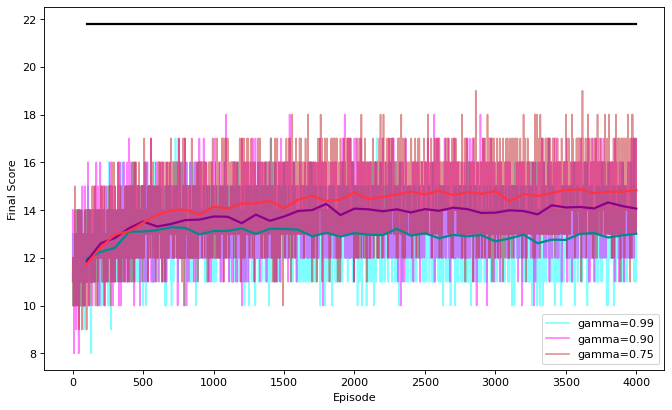

In [44]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_gamma_0p99[:4000], scores_2act_gamma_0p9[:4000], scores_2act_gamma_0p75[:4000], "gamma=0.99", "gamma=0.90", "gamma=0.75")

aux_plots.moving_average(scores_2act_gamma_0p99[:4000], ax, label="gamma=0.99", color='darkcyan')
aux_plots.moving_average(scores_2act_gamma_0p9[:4000], ax, label="gamma=0.90", color='darkmagenta')
aux_plots.moving_average(scores_2act_gamma_0p75[:4000], ax, label="gamma=0.75", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

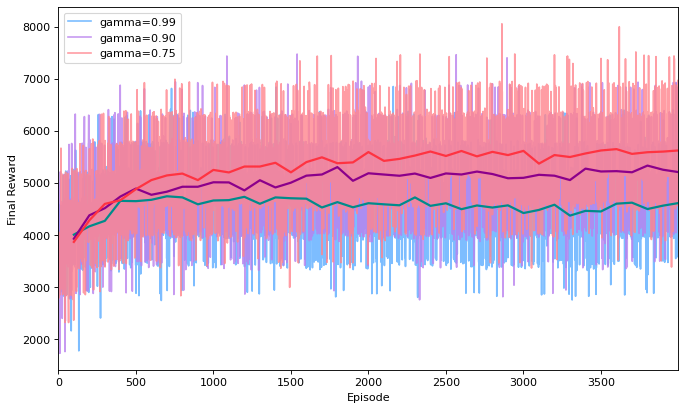

In [45]:
ax = aux_plots.plot_3rewards(total_rewards_2act_gamma_0p99[:4000], total_rewards_2act_gamma_0p9[:4000], total_rewards_2act_gamma_0p75[:4000], "gamma=0.99", "gamma=0.90", "gamma=0.75")

aux_plots.moving_average(total_rewards_2act_gamma_0p99[:4000], ax, label="gamma=0.99", color='darkcyan')
aux_plots.moving_average(total_rewards_2act_gamma_0p9[:4000], ax, label="gamma=0.90", color='darkmagenta')
aux_plots.moving_average(total_rewards_2act_gamma_0p75[:4000], ax, label="gamma=0.75", color='#FF3341')

### Influence of the $N0$ parameter that is used to define the agent's exploration rate  $\epsilon$

The exploration rate is the probability that our agent will explore the environment rather than exploit it.  
The $𝑁0$ parameter is used to define the agent's exploration rate $\epsilon$ , where  $\epsilon = N0/(N0+n)$ and $n$ is the number of times that state has been visited.  
<br>
As we did for the Q-learning agent, we used a $N0$ value very small (0.001) in order to make our agent short-sighned by only considering immediate rewards, and also used another two values of 2.5 and 5 to compare the results and see how they can impact the agent behavior. 

In [46]:
scores_2act_N0_0 = read_int_array_from_file('./MC/MC_scores_2act_N0_0.txt')
scores_2act_N0_25 = read_int_array_from_file('./MC/MC_scores_2act_R3.txt')
scores_2act_N0_5 = read_int_array_from_file('./MC/MC_scores_2act_N0_5.txt')

total_rewards_2act_N0_0 = read_int_array_from_file('./MC/MC_total_rewards_2act_N0_0.txt')
total_rewards_2act_N0_25 = read_int_array_from_file('./MC/MC_total_rewards_2act_R3.txt')
total_rewards_2act_N0_5 = read_int_array_from_file('./MC/MC_total_rewards_2act_N0_5.txt')

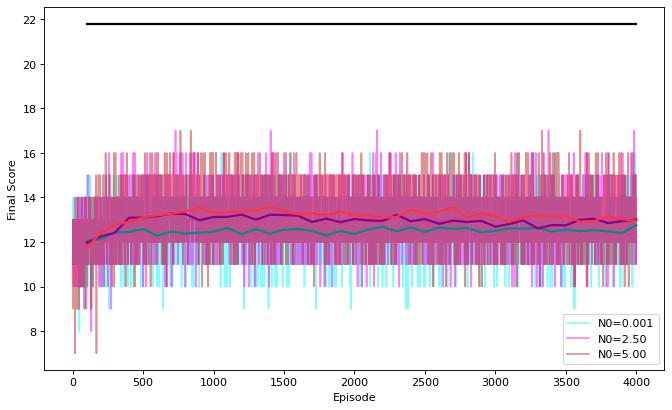

In [47]:
baseline = [baseline_mean_score for i in range(4000)]

ax = aux_plots.plot_3scores(scores_2act_N0_0[:4000], scores_2act_N0_25[:4000], scores_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

aux_plots.moving_average(scores_2act_N0_0[:4000], ax, label="N0=0.001", color='darkcyan')
aux_plots.moving_average(scores_2act_N0_25[:4000], ax, label="N0=2.50", color='darkmagenta')
aux_plots.moving_average(scores_2act_N0_5[:4000], ax, label="N0=5.00", color='#FF3341')
aux_plots.moving_average(baseline, ax, label='Baseline', color='black')

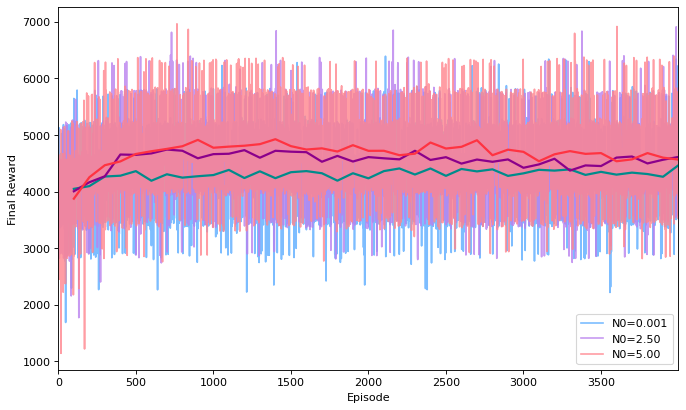

In [48]:
ax = aux_plots.plot_3rewards(total_rewards_2act_N0_0[:4000], total_rewards_2act_N0_25[:4000], total_rewards_2act_N0_5[:4000], "N0=0.001", "N0=2.50", "N0=5.00")

aux_plots.moving_average(total_rewards_2act_N0_0[:4000], ax, label="N0=0.001", color='darkcyan')
aux_plots.moving_average(total_rewards_2act_N0_25[:4000], ax, label="N0=2.50", color='darkmagenta')
aux_plots.moving_average(total_rewards_2act_N0_5[:4000], ax, label="N0=5.00", color='#FF3341')

## Visualizations and conclusions

Bellow you can find some gifs showing how the best MC agent behaved.
You will find the agent at different stages of training.

We can see that the chicken explores a lot in the first episodes, but it doesn't seem to learn how to evade the cars.
On the 4000th episode, it seems to try to go up as much as possible, leading to a lot of collisions, while in the earlier steps (2000, 1000...) it can be seem stopping frequently, but whitout meaning.
All in all, the MC didn't seem to work well for our problem, scoring about 13 points per run.

| #Episodes | 0 | 500 | 1000 | 2000 | 4000 |
|------|----|---|---|---|---|
| MC - R3 N2.5 G0.99 | ![QL-R3_0](./gif/MC-R3_0.gif) | ![QL-R3_500](./gif/MC-R3_500.gif) | ![QL-R3_1000](./gif/MC-R3_1000.gif) | ![QL-R3_2000](./gif/MC-R3_2000.gif) | ![QL-R3_4000](./gif/MC-R3_4000.gif) |

---

# SARSA($\lambda$)

SARSA is an on-policy reinforcement learning technique, while Q-Learning is considered to be off-policy.

The main difference is that SARSA tries to learn the Q table regarding a policy that it is following, while Q-Learning uses a greedy policy.
In other words, Q-Learning updates its Q comparing the difference between the Q of the old state and the Q of the new state, while SARSA uses a weighted sum of *all* the action values.

In [49]:
env, initial_state = environment.get_env()

In [50]:
agent = agents.SarsaLambda(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0, lambd=LAMBD)

In [51]:
scores = []
total_rewards = []

In [52]:
%%time
n_runs = 1

for i in range(n_runs):
    render = i % 200 == 199
    
    agent.reset_E()

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
    
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.005)
            env.render()

        old_state = state
        old_action = action
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        action = agent.act(state)  # Next action

        agent.update_Q(old_s=old_state, new_s=state, old_a=old_action, new_a=action, reward=reward)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Run [   0] - Total reward:   13.00 Mean scores: 13.00 Means Scores[:-10]: 13.00 Score: 13 
CPU times: user 9.25 s, sys: 3.36 ms, total: 9.26 s
Wall time: 9.29 s


## Influence of the $\lambda$ parameter

Here we will explore the impact that $\lambda$ has on our problem.

In [55]:
scores_SARSA_R3_L00 = read_int_array_from_file('SARSA/SARSA_R3_L00.txt')
scores_SARSA_R3_L02 = read_int_array_from_file('SARSA/SARSA_R3_L02.txt')
scores_SARSA_R3_L04 = read_int_array_from_file('SARSA/SARSA_R3_L04.txt')
scores_SARSA_R3_L06 = read_int_array_from_file('SARSA/SARSA_R3_L06.txt')
scores_SARSA_R3_L08 = read_int_array_from_file('SARSA/SARSA_R3_L08.txt')
scores_SARSA_R3_L10 = read_int_array_from_file('SARSA/SARSA_R3_L10.txt')

total_rewards_SARSA_R3_L00 = read_int_array_from_file('SARSA/rewards_SARSA_R3_L00.txt')
total_rewards_SARSA_R3_L02 = read_int_array_from_file('SARSA/rewards_SARSA_R3_L02.txt')
total_rewards_SARSA_R3_L04 = read_int_array_from_file('SARSA/rewards_SARSA_R3_L04.txt')
total_rewards_SARSA_R3_L06 = read_int_array_from_file('SARSA/rewards_SARSA_R3_L06.txt')
total_rewards_SARSA_R3_L08 = read_int_array_from_file('SARSA/rewards_SARSA_R3_L08.txt')
total_rewards_SARSA_R3_L10 = read_int_array_from_file('SARSA/rewards_SARSA_R3_L10.txt')

Text(0, 0.5, 'Final Score')

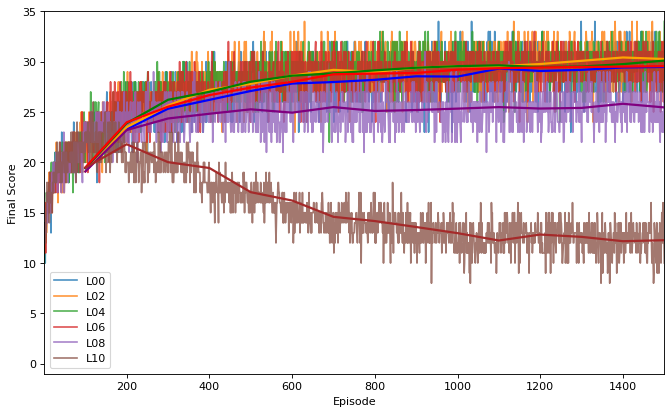

In [56]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)
l = len(scores_SARSA_R3_L00)

ax.set_xlim(0.9, l + 0.1)
ax.set_ylim(-1, 35)
ax.plot(range(1, l + 1), scores_SARSA_R3_L00, alpha=0.8, label='L00')
ax.plot(range(1, l + 1), scores_SARSA_R3_L02, alpha=0.8, label='L02')
ax.plot(range(1, l + 1), scores_SARSA_R3_L04, alpha=0.8, label='L04')
ax.plot(range(1, l + 1), scores_SARSA_R3_L06, alpha=0.8, label='L06')
ax.plot(range(1, l + 1), scores_SARSA_R3_L08, alpha=0.8, label='L08')
ax.plot(range(1, l + 1), scores_SARSA_R3_L10, alpha=0.8, label='L10')
plt.legend()
aux_plots.moving_average(scores_SARSA_R3_L00, ax, label="L00", color='blue')
aux_plots.moving_average(scores_SARSA_R3_L02, ax, label="L02", color='orange')
aux_plots.moving_average(scores_SARSA_R3_L04, ax, label="L04", color='green')
aux_plots.moving_average(scores_SARSA_R3_L06, ax, label="L06", color='red')
aux_plots.moving_average(scores_SARSA_R3_L08, ax, label="L08", color='purple')
aux_plots.moving_average(scores_SARSA_R3_L10, ax, label="L10", color='brown')

plt.xlabel("Episode")
plt.ylabel("Final Score")

Text(0, 0.5, 'Total Reward')

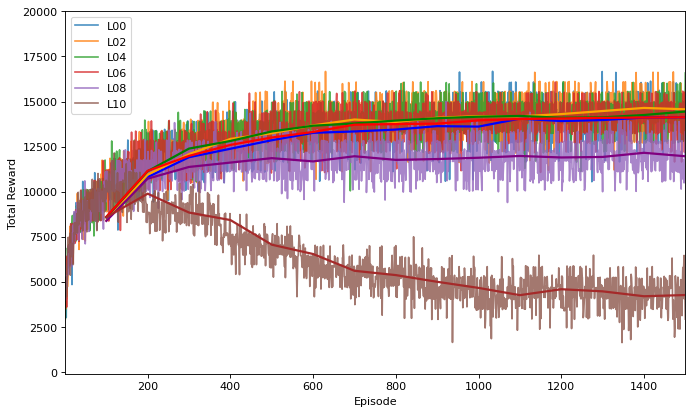

In [57]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)
l = len(scores_SARSA_R3_L00)

ax.set_xlim(0.9, l + 0.1)
ax.set_ylim(-100, 20000)
ax.plot(range(1, l + 1), total_rewards_SARSA_R3_L00, alpha=0.8, label='L00')
ax.plot(range(1, l + 1), total_rewards_SARSA_R3_L02, alpha=0.8, label='L02')
ax.plot(range(1, l + 1), total_rewards_SARSA_R3_L04, alpha=0.8, label='L04')
ax.plot(range(1, l + 1), total_rewards_SARSA_R3_L06, alpha=0.8, label='L06')
ax.plot(range(1, l + 1), total_rewards_SARSA_R3_L08, alpha=0.8, label='L08')
ax.plot(range(1, l + 1), total_rewards_SARSA_R3_L10, alpha=0.8, label='L10')
plt.legend()
aux_plots.moving_average(total_rewards_SARSA_R3_L00, ax, label="L00", color='blue')
aux_plots.moving_average(total_rewards_SARSA_R3_L02, ax, label="L02", color='orange')
aux_plots.moving_average(total_rewards_SARSA_R3_L04, ax, label="L04", color='green')
aux_plots.moving_average(total_rewards_SARSA_R3_L06, ax, label="L06", color='red')
aux_plots.moving_average(total_rewards_SARSA_R3_L08, ax, label="L08", color='purple')
aux_plots.moving_average(total_rewards_SARSA_R3_L10, ax, label="L10", color='brown')
plt.xlabel("Episode")
plt.ylabel("Total Reward")

We can see that SARSA converges fairly quickly regarding the number of episodes required, when compared to Monte Carlo and Q-Learning methods.
However, it is worth mentioning that SARSA takes a lot more time to run than Q-Learning/Monte Carlo!

## Visualizations and conclusions

Bellow you can find some gifs showing how the SARSA algorithm performed for different values of $\lambda$, after 1.5k episodes each.

It achieved the best scores with $\lambda = 0.2$, and **sometimes it even score the state-of-the-art score: 34 points**!
$\lambda$s between 0.0 and 0.6 also persented a wonderful performance, being really close to the one obtained using $\lambda = 0.2$.
On the other hand, $\lambda$s of 0.8 and 1.0 didn't do so well, with $\lambda=1.0$ being bellow our baseline.

All in all, we are really satisfied with SARSA($\lambda$), despite it taking a lot of time to train.

| $\lambda$ | 0.0 | 0.2 | 0.4 | 0.6 | 0.8 | 1.0 |
|------|----|---|---|---|---|---|
| SARSA - R3 N0.001 G0.99 | ![SARSA_R3_L00](./gif/SARSA_R3_L00.gif) | ![SARSA_R3_L02](./gif/SARSA_R3_L02.gif) | ![SARSA_R3_L04](./gif/SARSA_R3_L04.gif) | ![SARSA_R3_L06](./gif/SARSA_R3_L06.gif) | ![SARSA_R3_L08](./gif/SARSA_R3_L08.gif) | ![SARSA_R3_L10](./gif/SARSA_R3_L10.gif) |

# Linear function approximators

The previous algorithms aim to solve control problems using a model free approach that depends on Q tables, which are structures that store the values associated with how good it is to take an action A in a state S, called Q values.

Although using Q tables are good for solving small learning problems, they suffer with a trouble called the curse of dimensionality, in which even some small environments can generate a huge amount of possible states, requiring a large amount of memory that is not available. This drawback often prevents those techniques to be used in many tasks from real life that could benefit from it.

One of the solutions developed to deal with this problem is Function Approximation. On it, instead of trying to find the optimal values for a very large table, we try to find the best parameters for a parameterized function whose objective is to approximate the optimal values that we would find on that table.

Mathematically, we say that we have a family of parameterized functions $\mathcal{Q}$ given by $Q_{\theta}: S\times A \rightarrow \mathbb{R}$, where $\theta$ is an array of parameters in $\mathbb{R}^d$, called weights, and $d << |S|$. Given that, the objective of a function approximator is to find the array of weights $\theta^*$ that produces the $Q_{\theta}^*$ that better approximates the optimal Q values ($Q^*$) for the problem addressed. Some of the greatest advantages of these algorithms is that they learn to generalize for unseen states and requires a much smaller set of values to be learned (d instead of |S|).

For this project, we experimented with linear function approximators, which are given by the following equation, where $\hat{q}(s,a)$ is the approximated value of choosing action **a** in state **s**, $\theta_i$ is the i-th element of the array of parameters and $x_i$ is a function that turns the action-state pair into the i-th feature of a d-dimensional feature array.

$\hat{q}(s,a,\theta) = \sum_{i = 1}^d \theta_i*x_i(s,a)$

In order to discover the best parameters, we applied a Stochastic Gradient Descent algorithm to update the weights, given by the equation below:

$\theta = \theta + \alpha*(target - \hat{q}(S_t, A_t, \theta))*x(S_t, A_t)$

The **target** is the value that our function approximator tries to achieve at each update and it changes for each algorithm approximated (Monte Carlo, Q Learning and Sarsa Lambda), and $\alpha$ is a learning step size.

One of the critical points of function approximators is the choice of the features to be used to represent the states. Depending on their choice, we can build good or bad function approximators. For this project, we experimented with a set of different features, as described in the next sections.

## Auxiliary functions

In [58]:
RAM_full_mask=[14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 18  # Chicken Collision flag (with the bottom car)
    , 22  # Car X Direction
    , 23, 24, 25, 26, 27, 28, 29, 30, 31, 32  # Z Car Patterns
    , 33, 34, 35, 36, 37, 38, 39, 40, 41, 42  # Car Motion Timmers
    , 43, 44, 45, 46, 47, 48, 49, 50, 51, 52  # Car Motions
    , 87, 88  # Car Shape Ptr
    # TODO: test if this makes any difference
    , 89, 90  # Chicken Shape Ptr
    # TODO: test if this makes any difference
    #, 106, 107  # Chicken Sounds
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]  # Car X Coords


def reduce_state_abs_neg(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        ob[b] = abs(ob[b] - 50)
        
        if b <= 112:
            ob[b] = -ob[b]
     
        ob[b] = ob[b] // 3

    return ob


def runGame(env, agent, mask, reduce_state, reduce=True):
    
    actions = []
    score = 0
    total_reward = 0
    
    state = env.reset()
    if reduce:
        state = reduce_state(state)[mask].data.tobytes()  # Select useful bytes
    else:
        state = state[mask].data.tobytes()
        
    action = agent.act(state)
    actions.append(action)
    
    game_over = False
    render  = True
    while not game_over:
        if render:
            time.sleep(0.0025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)
        
        if reward == 1:
            score+=1
        total_reward+=reward
        
        if reduce:
            state = reduce_state(ob)[mask].data.tobytes()
        else:
            state = ob[mask].data.tobytes()
            
        action = agent.act(state)
        actions.append(action)
    
    return score, total_reward, actions

## Q Learning Function Approximation

For the Q learning function approximator, we decided to use the best parameters found for the Q learning algorithm shown before. They were: 
- $\gamma = 0,99$
- N0 = 0,001
- 2 available actions (move up and stay)
- A reward of 500 if the chicken crosses the street, a reward of -10 if it collides with a car and a reward of -1 if the chicken decides to stay.

One important detail is that, for the function approximator we decided to use a fixed step size $\alpha = 0,00001$. It happened because, when we were using the time varying step size used for the previous algorithms, its values were still much bigger than the necessary for the function approximator error converge, making the score and reward curves decrease instead of increase. With the smaller fixed value of $\alpha$, the updates started to help the algorithm to learn.


### Experiment A (Original approximator)

In the figures in this section, we can see the scores and the rewards achieved by the function approximator when it ran for 6000 episodes. As we can see, the scores and rewards were smaller than those achieved for the best Q learning algorithm, and the scores are close to those found for the baseline, which just moves up. 

We also can see that, in the first 500 episodes, the agent achieves bigger scores, with a mean of 23 and maximum value achieving 27 points. However, soon the agent starts to get worse scores and they seem to stabilize close to 21,5 after a few more episodes, varying just a little around it. Also, it is possible to see that the original curve spans a more behaved range of scores. 

The mean score and reward achieved by this agent were 21,49 and 10043,16, respectively. This results indicates that the agent is possibly learning to move up almost every time, what is close to the behavior of the baseline. To check this hypothesis, we watched a sample episode of this agent and saw that the agent chose to move up in all time steps. One possible explanation for it is the small value of N0, which implies a smaller exploration by the agent that seems it is not being enough.

In [59]:
path = './serialized_models/'
model_exp08 = serializer.Experiment.load_experiment(path+'exp08_model_baseline_ql_approximator_6000_2020_12_26_10_07_09.dill')

In [60]:
mean_score_exp08 = np.sum(model_exp08.scores)/len(model_exp08.scores)
mean_reward_exp08 = np.sum(model_exp08.total_rewards)/len(model_exp08.total_rewards)
mean_weights_exp08 = np.sum(model_exp08.agent.W)/len(model_exp08.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp08, mean_reward_exp08, mean_weights_exp08))

Mean score: 21.490666666666666, Mean reward: 10043.158333333333, Mean weights: 43.24854128267378


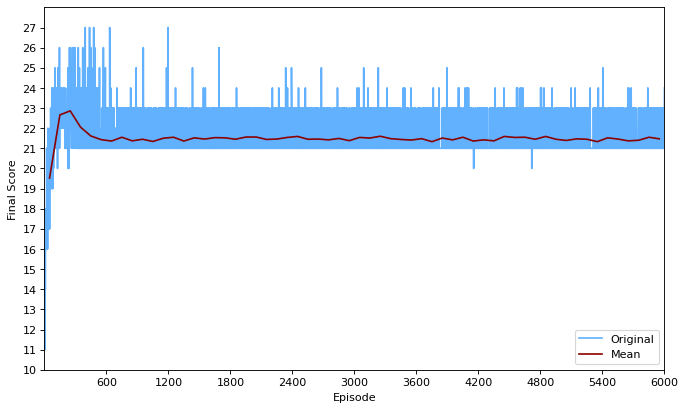

In [61]:
aux_plots.plot_scores_mean(model_exp08.scores)

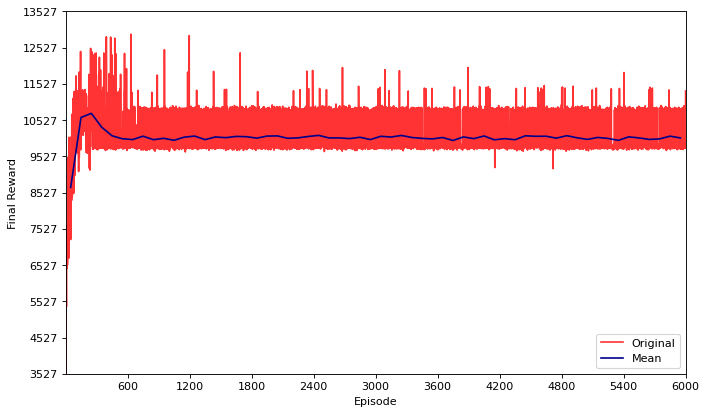

In [62]:
aux_plots.plot_rewards_mean(model_exp08.total_rewards, 1000)

In [63]:
env, initial_state = environment.get_env()
model_exp08.agent.trainScaler(env, RAM_mask)

score_exp08, reward_exp08, actions_exp08 = runGame(env,model_exp08.agent, RAM_mask, reduce_state, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp08, reward_exp08, np.unique(actions_exp08, return_counts=True)))

Score: 21, Reward: 21.0, Actions: (array([1]), array([2735]))


### Experiment B (Features without reduce)

In order to analyse the influence of the features used to represent the state-action pairs, we decided to perform some experiments varying these features and keeping those hyperparameters. 

So, the next experiment we performed was the creation of an agent using no reduction to represent the states. We hypothesized that maybe if the agent had a wider view of the environment, it could help it to take better decisions.

This time, the mean score and reward were 21,39 and 9942,23, respectively, which are smaller than those achieved by the previous agent. This indicates that the pre-processed states built with the reduced features provides much better information to the agent than using the raw values obtained from the RAM. However, we can see that the agent scores start to decrease a little later and that the score curve is less behaved than that of the previous agent. This can indicate that the learning process of this agent is slower than that of the original agent. Again, running an episode of the game, the agent always chose to move up.

In [64]:
path = './serialized_models/'
model_exp04 = serializer.Experiment.load_experiment(path+'exp04_model_no_reduce_ql_approximator_6000_2020_12_26_00_25_50.dill')

In [65]:
mean_score_exp04 = np.sum(model_exp04.scores)/len(model_exp04.scores)
mean_reward_exp04 = np.sum(model_exp04.total_rewards)/len(model_exp04.total_rewards)
mean_weights_exp04 = np.sum(model_exp04.agent.W)/len(model_exp04.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp04, mean_reward_exp04, mean_weights_exp04))

Mean score: 21.378166666666665, Mean reward: 9942.233833333334, Mean weights: 25.105749743269037


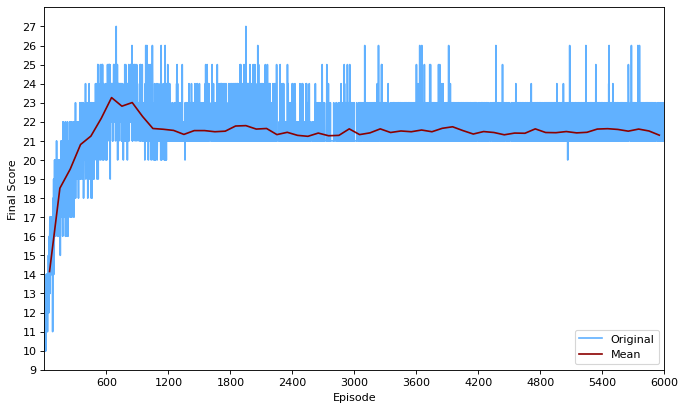

In [66]:
aux_plots.plot_scores_mean(model_exp04.scores)

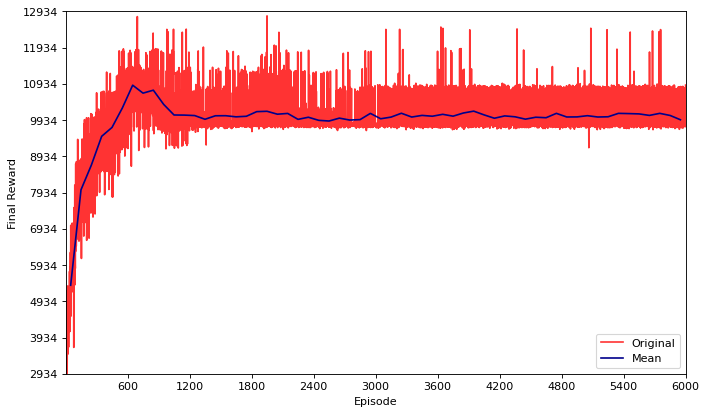

In [67]:
aux_plots.plot_rewards_mean(model_exp04.total_rewards, 1000)

In [68]:
env, initial_state = environment.get_env()
model_exp04.agent.trainScaler(env, RAM_mask)

score_exp04, reward_exp04, actions_exp04 = runGame(env,model_exp04.agent, RAM_mask, reduce_state, False)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp04, reward_exp04, np.unique(actions_exp04, return_counts=True)))

Score: 21, Reward: 21.0, Actions: (array([1]), array([2742]))


### Experiment C (Distance features)

Another idea of features that we tried to use with the function approximators was to show to the agent not the position, but the distance each car was from it. Also, we hypothesized that, once half of the cars walk in a direction while the other half walk in the opposite direction, show this to the agent, turning negative the first half of the distances, could also help the agent to better understand the environment and choose better actions.

As we can see in the figures below, these features bring better results than using no pre-processing on the states, but achieved slightly worse results than the original agent, with a mean score and a mean reward of 21,47 and 10025,16. We also can see that the scores started to decrease earlier than the two others seen before and that the curve is a little less behaved than the original, especially in the latter episodes. Again, running an episode, the agent always chooses to move up.

In [69]:
path = './serialized_models/'
model_exp10 = serializer.Experiment.load_experiment(path+'exp10_model_abs_neg_div3_ql_approximator_6000_2020_12_26_10_16_00.dill')

In [70]:
mean_score_exp10 = np.sum(model_exp10.scores)/len(model_exp10.scores)
mean_reward_exp10 = np.sum(model_exp10.total_rewards)/len(model_exp10.total_rewards)
mean_weights_exp10 = np.sum(model_exp10.agent.W)/len(model_exp10.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp10, mean_reward_exp10, mean_weights_exp10))

Mean score: 21.469833333333334, Mean reward: 10025.157, Mean weights: 45.36141153190517


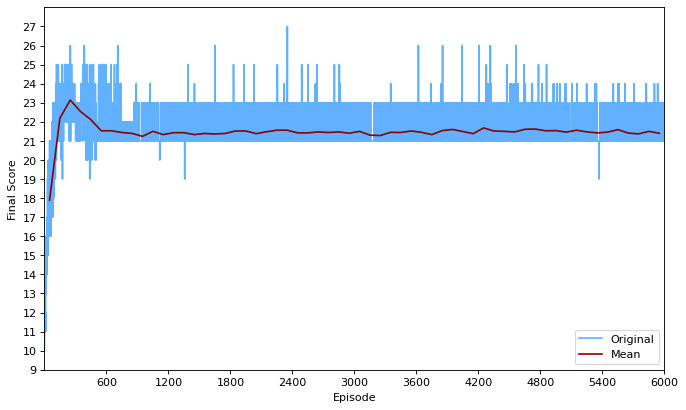

In [71]:
aux_plots.plot_scores_mean(model_exp10.scores)

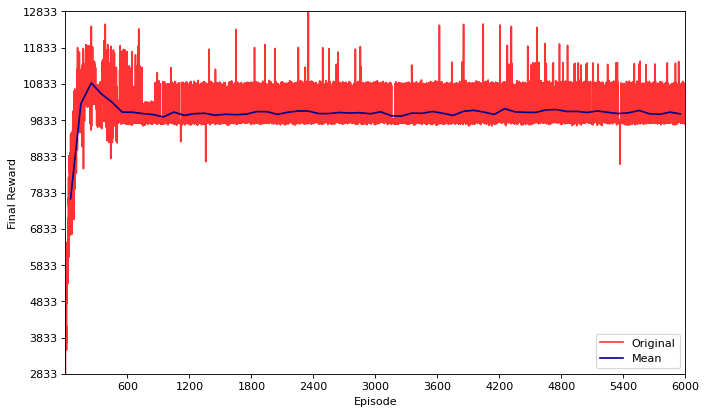

In [72]:
aux_plots.plot_rewards_mean(model_exp10.total_rewards, 1000)

In [73]:
env, initial_state = environment.get_env()
model_exp10.agent.trainScaler(env, RAM_mask)

score_exp10, reward_exp10, actions_exp10 = runGame(env,model_exp10.agent, RAM_mask, reduce_state_abs_neg, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp10, reward_exp10, np.unique(actions_exp10, return_counts=True)))

Score: 23, Reward: 23.0, Actions: (array([1]), array([2713]))


### Experiment D (Distance features and more RAM)

The next experiment we performed tried to see if passing more information about the environment to the agent, through more RAM bytes that encodes, for example, chicken shapes and car timers, could help in its learning process. For this, we kept the states preprocessing of the previous agent, but we gave more RAM positions.

As can be seen in the figures below, the agent score still starts to decrease earlier, but the curve is less noisy for the latter episodes. The mean score and reward for this agent were 21,44 and 10007,21. Again, the agent decided to always move up when running an episode.


As we could see for the four experiments discussed, the agent is not improving over the baseline. Despite that, the changes in the features generated different behaviors for the agents in the earlier episodes, even converging to a similar bad behavior in the last episodes. Moreover, the creation of more noisy or well behaved score and reward curves indicates the influence of the exploration policy adopted. More well behaved curves indicates that the agent is trying more the best action than exploring other possibilities. More noisy curves could indicate that the presented features could help the agent to achieve better results, probably, if it didn’t always choose the best action.


In [74]:
path = './serialized_models/'
model_exp09 = serializer.Experiment.load_experiment(path+'exp09_model_all_ram_abs_neg_ql_approximator_6000_2020_12_26_10_02_43.dill')

In [75]:
mean_score_exp09 = np.sum(model_exp09.scores)/len(model_exp09.scores)
mean_reward_exp09 = np.sum(model_exp09.total_rewards)/len(model_exp09.total_rewards)
mean_weights_exp09 = np.sum(model_exp09.agent.W)/len(model_exp09.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp09, mean_reward_exp09, mean_weights_exp09))

Mean score: 21.443, Mean reward: 10007.2105, Mean weights: 7.128450485570442


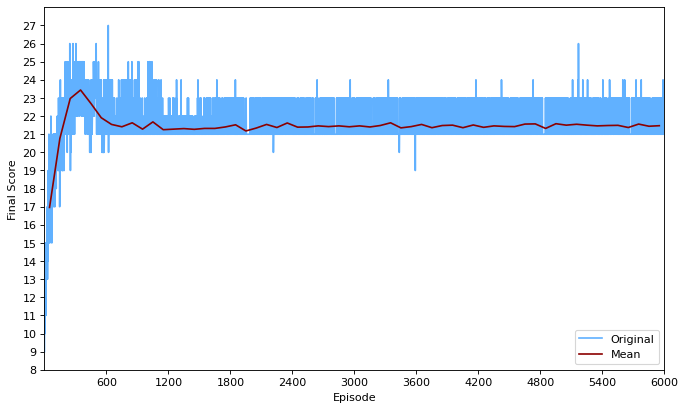

In [76]:
aux_plots.plot_scores_mean(model_exp09.scores)

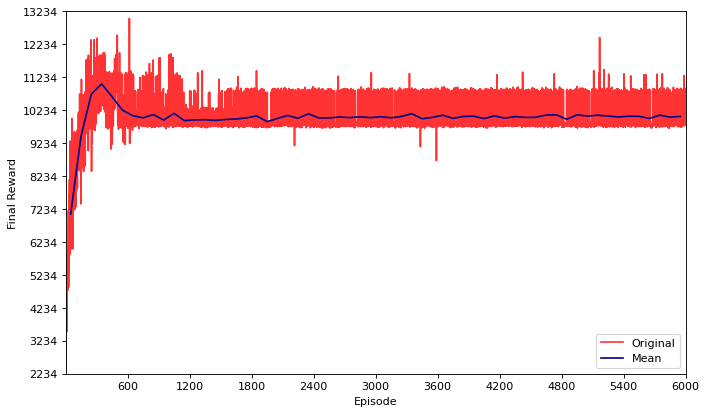

In [77]:
aux_plots.plot_rewards_mean(model_exp09.total_rewards, 1000)

In [78]:
env, initial_state = environment.get_env()
model_exp09.agent.trainScaler(env, RAM_full_mask)

score_exp09, reward_exp09, actions_exp09 = runGame(env,model_exp09.agent, RAM_full_mask, reduce_state_abs_neg, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp09, reward_exp09, np.unique(actions_exp09, return_counts=True)))

Score: 21, Reward: 21.0, Actions: (array([1]), array([2737]))


### Experiment E (Exploring more)

Given the results obtained with the hyperparameters shown before, we decided to let the Q learning approximator to explore more, now giving N0 = 2,5. 

In the figures below, we can see that the score and reward curves changed their shapes, not presenting that big decrease in the first episodes. The bigger exploration manifests in the noisier curves, showing that sometimes the agent chooses actions that drive it to greater scores and rewards, and other times its decisions generate bad results, as expected from an agent that is exploring more.

This time, the mean score and reward were 22,61 and 10560,47, which are better than the baseline and the previous results, but still worse than the best results achieved for the Q learning model without function approximation. Moreover, now the agent chooses to don’t move in some time steps. For a sample running, the agent chose to don’t move for 14 of the 2754 time steps. These results indicate that now we were able to build an agent that decides better when to take a given action in a given situation.

In [79]:
path = './serialized_models/'
model_exp02 = serializer.Experiment.load_experiment(path+'exp02_model_r3_ql_approximator_6000_2020_12_25_12_00_15.dill')

In [80]:
mean_score_exp02 = np.sum(model_exp02.scores)/len(model_exp02.scores)
mean_reward_exp02 = np.sum(model_exp02.total_rewards)/len(model_exp02.total_rewards)
mean_weights_exp02 = np.sum(model_exp02.agent.W)/len(model_exp02.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp02, mean_reward_exp02, mean_weights_exp02))

Mean score: 22.6125, Mean reward: 10560.471333333333, Mean weights: 58.32817639375868


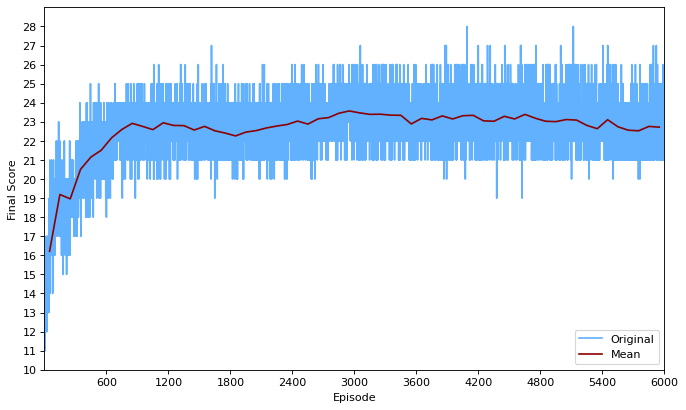

In [81]:
aux_plots.plot_scores_mean(model_exp02.scores)

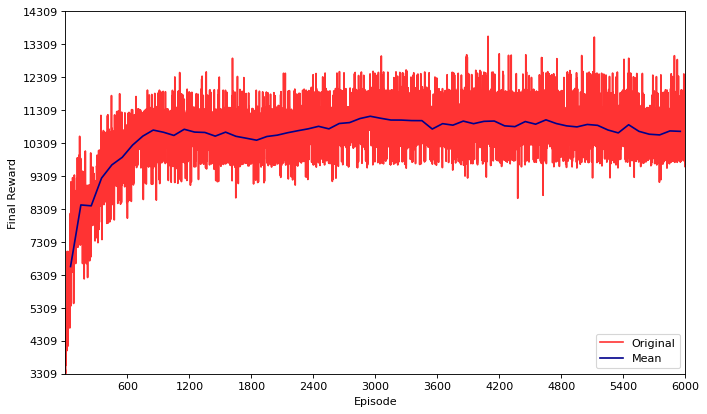

In [82]:
aux_plots.plot_rewards_mean(model_exp02.total_rewards, 1000)

In [83]:
setattr(model_exp02.agent, 'feat_type', 'all')
env, initial_state = environment.get_env()
model_exp02.agent.trainScaler(env, RAM_mask)

score_exp02, reward_exp02, actions_exp02 = runGame(env,model_exp02.agent, RAM_mask, reduce_state, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp02, reward_exp02, np.unique(actions_exp02, return_counts=True)))

Score: 21, Reward: 21.0, Actions: (array([0, 1]), array([  17, 2724]))


### Experiment F (-50 for collision)

Given that the results of the Q learning approximator were not good enough, compared with the Q learning without the approximation, we tried to perform other changes that could help the agent to learn. Watching some episodes of the created agent, we saw that it was colliding with cars a lot of times. So, we hypothesized that changing the reward function, given a bigger negative value for the collision, would help the agent to learn to collide less.

To check it, we performed two more experiments, keeping N0 equal to 2,5. In one of them we gave a reward of -50 when the chicken collided with a car, and in the other we gave a reward of -100.

The two figures below show the results for the reward of -50. As we can see, the curve of scores is very similar to that using the original rewards. Nevertheless, the reward curve shows much more variation in its values, as a consequence of the bigger negative reward. These results indicate that this change in the reward function was not able to decrease sufficiently the number of collisions.  The mean score and reward for this agent were 22,54 and 7876,18, which are smaller than that of the agent with the original reward policy. And, again, the agent learned to don’t move in some few situations.


In [84]:
path = './serialized_models/'
model_exp11 = serializer.Experiment.load_experiment(path+'exp11_model_r50_approximator_6000_2020_12_26_22_27_33.dill')

In [85]:
mean_score_exp11 = np.sum(model_exp11.scores)/len(model_exp11.scores)
mean_reward_exp11 = np.sum(model_exp11.total_rewards)/len(model_exp11.total_rewards)
mean_weights_exp11 = np.sum(model_exp11.agent.W)/len(model_exp11.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp11, mean_reward_exp11, mean_weights_exp11))

Mean score: 22.544166666666666, Mean reward: 7876.183, Mean weights: 44.923679223856524


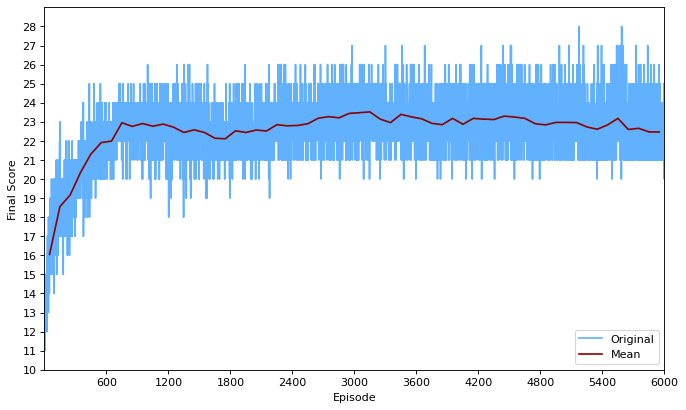

In [86]:
aux_plots.plot_scores_mean(model_exp11.scores)

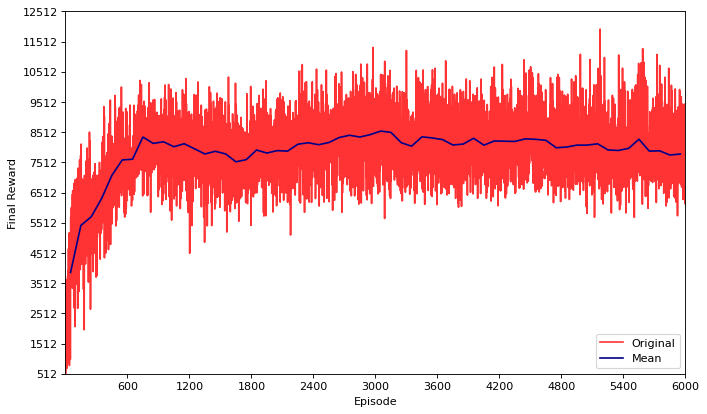

In [87]:
aux_plots.plot_rewards_mean(model_exp11.total_rewards, 1000)

In [88]:
env, initial_state = environment.get_env()
model_exp11.agent.trainScaler(env, RAM_mask)

score_exp11, reward_exp11, actions_exp11 = runGame(env,model_exp11.agent, RAM_mask, reduce_state, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp11, reward_exp11, np.unique(actions_exp11, return_counts=True)))

Score: 25, Reward: 25.0, Actions: (array([0, 1]), array([  45, 2700]))


### Experiment G (-100 for collision)

Using a reward of -100 when the chicken collides with a car gaves us a score curve that is slightly more stable than using a reward of -50. However, it is still very similar with the score curve built using the original reward policy. The reward curve, on the other hand, has much bigger amplitudes than the other two, as expected, but also has less variant mean values. The mean score and reward for this agent were 22,59 and 4617,35, and it also choses to don’t move in some time steps, but in less time steps than the other two.

With these results we could see that changes in the reward policy was not good enough to prevent the chicken from colliding and, consequently, achieving better scores.


In [89]:
path = './serialized_models/'
model_exp12 = serializer.Experiment.load_experiment(path+'exp12_model_r100_approximator_6000_2020_12_26_23_04_24.dill')

In [90]:
mean_score_exp12 = np.sum(model_exp12.scores)/len(model_exp12.scores)
mean_reward_exp12 = np.sum(model_exp12.total_rewards)/len(model_exp12.total_rewards)
mean_weights_exp12 = np.sum(model_exp12.agent.W)/len(model_exp12.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp12, mean_reward_exp12, mean_weights_exp12))

Mean score: 22.595666666666666, Mean reward: 4617.357, Mean weights: 28.691696205376754


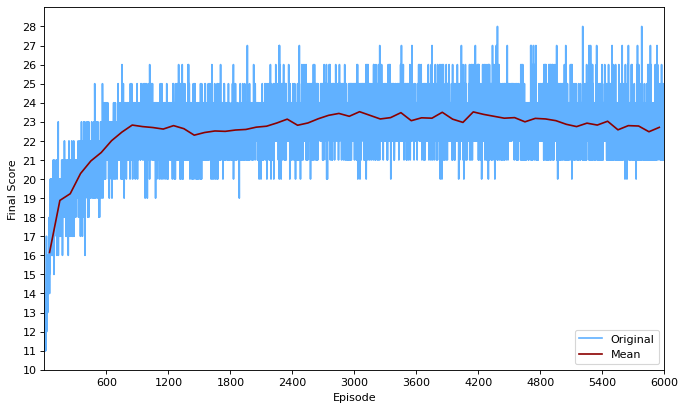

In [91]:
aux_plots.plot_scores_mean(model_exp12.scores)

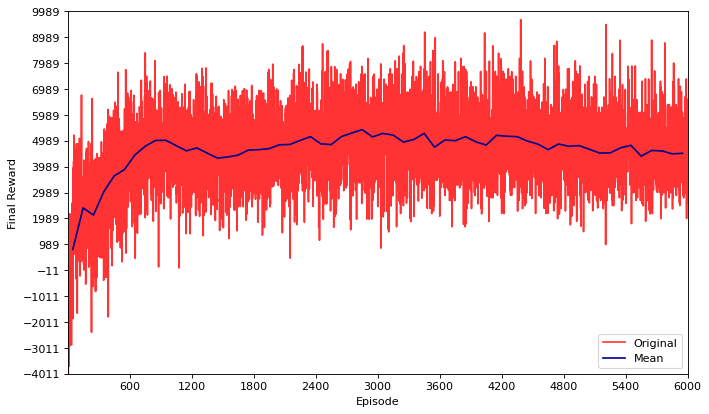

In [92]:
aux_plots.plot_rewards_mean(model_exp12.total_rewards, 1000)

In [93]:
env, initial_state = environment.get_env()
model_exp12.agent.trainScaler(env, RAM_mask)

score_exp12, reward_exp12, actions_exp12 = runGame(env,model_exp12.agent, RAM_mask, reduce_state, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp12, reward_exp12, np.unique(actions_exp12, return_counts=True)))

Score: 24, Reward: 24.0, Actions: (array([0, 1]), array([  12, 2740]))


### Visualizations and conclusions

In the table below we can see a summary of the mean scores and rewards for each experiment.

| Experiment | Mean Score | Mean Reward |
|:----------:|:----------:|:-----------:|
|      A     |    21,49   |   10043,16  |
|      B     |    21,39   |   9942,23   |
|      C     |    21,47   |   10025,16  |
|      D     |    21,44   |   10007,21  |
|      E     |    22,61   |   10560,47  |
|      F     |    22,54   |   7876,18   |
|      G     |    22,59   |   4617,35   |


As we could see from the results, the function approximation implemented for the Q learning algorithm didn’t improve the performance of the agents, compared to the Q learning without approximation, as we were expecting. Some factors could explain that, such as the choice of better hyperparameters, but one of the most important is the creation of the features.

As discussed in the introduction about function approximation, the features are a key factor for the success of these algorithms, both because they decrease the dimension space of the values we are trying to optimize and because they are responsible for expressing the most important information that the agent will use to learn about the environment.

Although the linear function approximators are powerful algorithms for a lot of reinforcement learning tasks, they have some disadvantages. One of them is its lack of capacity to express some kind of relationships between environment variables. For example, if a given variable represents a good event in the environment only in the absence of another, the linear approximator cannot parameterize that. In these cases, the features become responsible for representing the necessary information for the learning process, requiring good feature engineering.

Given that and the results achieved with function approximators in this project, we assume that the features chosen by us, probably, were not very representative of our problem, for function approximation. So, for future works, we need to investigate better representations and try with more complex function approximators, such as the nonlinear ones. Despite that, we could see how the exploration capacity of the agent  and the rewards chosen can impact how good it becomes, as well as how the learning step size contributes to the convergence of the algorithms.


In the table below we can see the gifs generated for 3 out of the 8 experiments performed for the Q Learning approximator: **A**, which uses the original model; **E**, that is the agent with N0 = 2,5; and **G**, where the agent receives a reward of -100 when collides with a car. Each gif executes 1000 time steps and they were produced for agents trained during 500, 1000 and 6000 episodes.

As we can see, there is not a big difference between the gifs of the same experiment, especially for those of experiments A and E. This reinforces the assumption that these agents are learning to act as the baseline, which is not the best behavior. However, in the gif for 500 episodes of experiment G, we can see that the agent suffers less collisions than the other examples (approximately 10 instead of 14, as the others), showing that for the first episodes that reward policy may be a little helpful.


| Episodes | Experiment A | Experiment E | Experiment G |
|:--------:|:------------:|:------------:|:------------:|
|    500   |     ![SegmentLocal](./gif/ql_lfa_exp_A_500.gif "segment")     |     ![SegmentLocal](./gif/ql_lfa_exp_E_500.gif "segment")     |     ![SegmentLocal](./gif/ql_lfa_exp_G_500.gif "segment")     |
|   1000   |     ![SegmentLocal](./gif/ql_lfa_exp_A_1000.gif "segment")     |     ![SegmentLocal](./gif/ql_lfa_exp_E_1000.gif "segment")    |     ![SegmentLocal](./gif/ql_lfa_exp_G_1000.gif "segment")    |
|   6000   |     ![SegmentLocal](./gif/ql_lfa_exp_A_6000.gif "segment")     |     ![SegmentLocal](./gif/ql_lfa_exp_E_6000.gif "segment")     |     ![SegmentLocal](./gif/ql_lfa_exp_G_6000.gif "segment")     |





# MC Function Approximation

## Features Methods

We developed four types of feature methods to represent our state and action. These methods are based on the RAM information, and they are divided into reduced and expanded RAM methods.
The first one constructs a representation omitting some information and the second one manages the RAM information to enrich the quality of the representation.

Addionally, we apply the Standard Scaling over the state information, we show all the RAM information in the next list.

### All Reduced Feature
We choose the values A, B, and L from the list and decide to transform some values of the RAM observation follow the next idea:
+ ob[16]: We don't require where the chicken was hit, we only need to know that was hit.
+ From ob[108] to ob[118]: We only save the information about the car that is close to the chicken.
+ We make ob[x]/3  $\forall x \in ${A,B,K} in order to reduce the space.

To do so, we use the same `reduce_state` function from before.

After we reduce the observation space, we scale these values and add the action and bias to construct our feature representation.

```python
feat_state = self.scaler.transform(state.reshape(1, -1))
            return np.append(feat_state, [action,1])
```

### Distance Features

This feature is similar to the reduce state with the difference that we do not set the values far away from the chicken to zero. Instead, we measure the distance of the car to the chicken and multiple the first five values by -1.

```python 
def reduce_state_distance(ob):
    ob[16] = 1 if ob[16] != 255 else 0
    ob[14] = ob[14] // 3
    for b in range(108, 118):
        ob[b] = abs(ob[b] - 50)
        if b<=112:
            ob[b]*=-1
        ob[b] = ob[b] // 3

    return ob
```





### Expand RAM Features

We decide to extend the information in the RAM using almost all the values with expection of the Chicken Sounds values and we do not apply any reduce method.

For our MonteCalor aproximator we generate the episodes related to the entired game. In the  following code, where S[t]: State, R[t]: Reward and A[t]: Action. In the timestep t, we show how the updating process of the weight are made.


```python
for t in range(episode.length - 1):

  self.state_visits_per_episode[S[t]] += 1
  # first visit to the state   
  if self.state_visits_per_episode[S[t]]==1:
    G=sum(R[t:])
    self.update_W(stateValue =S_array[t],action= A[t], reward =G)
```


For our Montecarlo approximation we tested over the four features representation described before using the parameters N0 = 2.5, available actions= 2, and gamma=0.99. Also, we use 2 kinds of rewards that we are going to refer to as R3 and R4. We choose this because it got the better performance for our experiments; they follow the next configuration:

+ R3: 
  + If cross = 500
  + Rewards if colision = -10
  + Rewards if still = -1

+ R4:
  + If cross = 500
  + Rewards if colision = -50
  + Rewards if still = -1
 

Each experiment takes a mean of almost 6h 17min to execute over 5000 games. Adio

### Results

#### Experiment using Feature 1


In the following figure, we notice a stationary behavior in our score using the *All Reduced Feature*. Also, we notice that the Montecarlo approximation could not achieve the baseline of 21.48. Similarly, the rewards followed the stationary behavior having negative values. 
The mean values for scores and rewards show us that the chicken was not capable to avoid the car collision. Even though there exist some episodes where the chicken could not achieve better result, we can consider that is learning to cross the way with is untypical behavior.

In [6]:
modelexp1 = serializer.Experiment.load_experiment('models/MontecarloAproximatorN0_2.5_Feature1_R3_5000_v2_2020_12_27_09_29_03.dill')

/home/visoc/anaconda3/envs/openai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [8]:
mean_score_exp1 = np.sum(modelexp1.scores)/len(modelexp1.scores)
mean_reward_exp1 = np.sum(modelexp1.total_rewards)/len(modelexp1.total_rewards)
mean_weights_exp1 = np.sum(modelexp1.agent.W)/len(modelexp1.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp1, mean_reward_exp1, mean_weights_exp1))

Mean score: 9.2258, Mean reward: 2420.847, Mean weights: -11.434053480252869


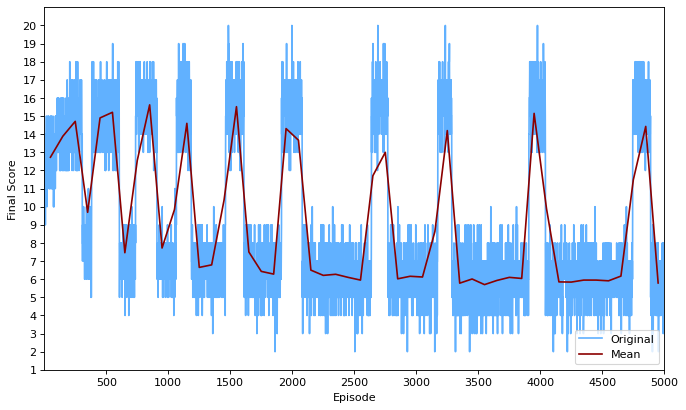

In [10]:
aux_plots.plot_scores_mean(modelexp1.scores)

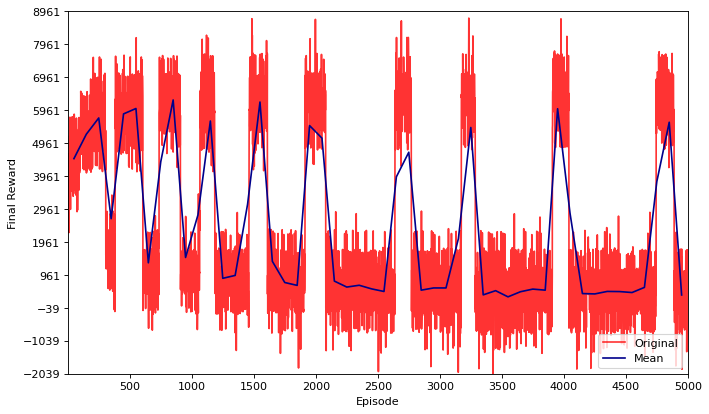

In [11]:
aux_plots.plot_rewards_mean(modelexp1.total_rewards, 1000)

#### Experiment using Feature 2
Once we change feature 1 (all reduce feature) to feature 2 (the distance feature). We notice an improvement in our chicken behavior, and now we got a better score higher than our defined baseline. We see that the information about the distance of the car to the chicken helps our models to quickly get better results. Also using the average rewards we can see that our rewards for each episode has a tendency to grow up.
However, there still exists some stationary behavior that is not so noisy as experiment 1.


In [12]:
modelexp2 = serializer.Experiment.load_experiment('models/MontecarloAproximatorN0_2.5_Feature3_R3_5000_v2_2020_12_27_09_54_31.dill')

/home/visoc/anaconda3/envs/openai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [13]:
mean_score_exp2 = np.sum(modelexp2.scores)/len(modelexp2.scores)
mean_reward_exp2 = np.sum(modelexp2.total_rewards)/len(modelexp2.total_rewards)
mean_weights_exp2 = np.sum(modelexp2.agent.W)/len(modelexp2.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp2, mean_reward_exp2, mean_weights_exp2))

Mean score: 22.2006, Mean reward: 10254.4112, Mean weights: 64.6336966812167


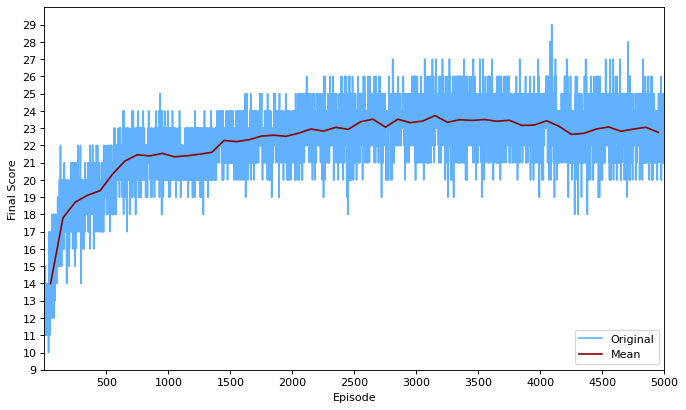

In [14]:
aux_plots.plot_scores_mean(modelexp2.scores)

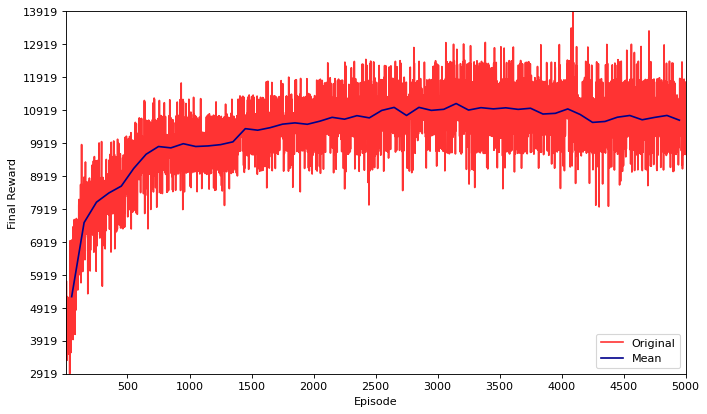

In [19]:
aux_plots.plot_rewards_mean(modelexp2.total_rewards, 1000)

#### Experiment Feature 3 
This experiment uses almost all the information in the RAM without applied any changes over the observation. We notice that there is a moment after 500 episodes where our chicken decides that was not good to try to move forwards because it is getting negative rewards as we see in the rewards graph. After that moment, they start to get back to the objective of the cross the way. 

In [16]:
modelexp3 = serializer.Experiment.load_experiment('models/MontecarloAproximatorN0_2.5_Feature4_R3_5000_v2_2020_12_27_11_48_45.dill')

/home/visoc/anaconda3/envs/openai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [17]:
mean_score_exp3 = np.sum(modelexp3.scores)/len(modelexp3.scores)
mean_reward_exp3 = np.sum(modelexp3.total_rewards)/len(modelexp3.total_rewards)
mean_weights_exp3 = np.sum(modelexp3.agent.W)/len(modelexp3.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp3, mean_reward_exp3, mean_weights_exp3))

Mean score: 21.2066, Mean reward: 9653.1906, Mean weights: -13.601536909494722


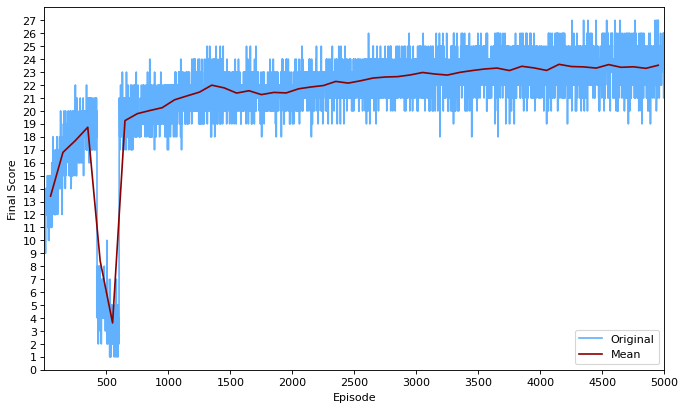

In [18]:
aux_plots.plot_scores_mean(modelexp3.scores)

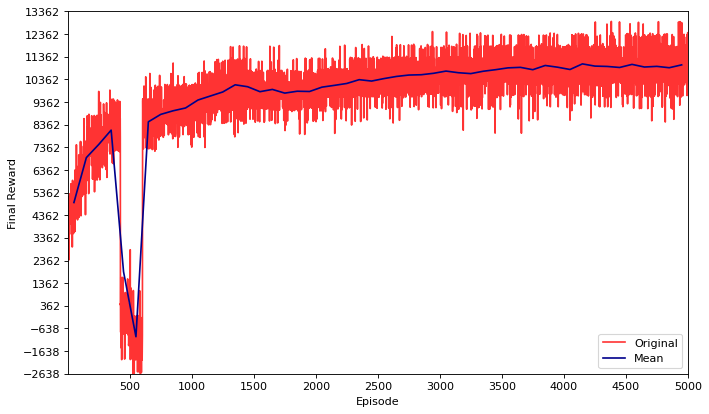

In [20]:
aux_plots.plot_rewards_mean(modelexp3.total_rewards, 1000)

## Summary tables

In the table below, we can notice see that due to the stationary behavior experiment 1 was not capable of getting a good result.
Also, we notice that experiment 2 achieve better results in terms of rewards and scores. Also, their mean weight is positive for this experiment.
Finally, we can say that in terms of score the experiment 3 achieve a closed high score related to the experiment 2.

| Experiment   | Mean Score | Mean Reward | Mean Weight |
|--------------|------------|-------------|-------------|
| Experiment 1 | 9.2258     | 2420.847    | -11.43      |
| Experiment 2 |    22.20   | 10254.41    | 64.63       |
| Experiment 3 |    21.20   | 9653.19     | -13.60      |

## Conclusion

Our experiment suggests that the choice of an appropriate feature could have a revelant result in our Montecarlo approximation. The result associate with Experiment 1 (All reduce State) hides some information that could help to get adequate weight.
On the other side, the result relates to feature 2 (Distance State), and feature 3 (Expanded State) shows us that it is not necessary to use all information to get a good result because experiment 2 got a similar result using a features vector with 35 fewer values than the experiment 3. Also, the stationary behavior of experiment 3 can be produced by the high number of state combination for its 35-size vector.


Addionationally the reducing of feature could have a negative effect in the motecarlo approximation because we add zero to the feature vector. This open the posibility to produce similar vector for different states(RAM in bytes); As Montecarlo make update for a new state, this representation could made updated more times the weight than the necesary.


# SARSA($\lambda$) Function Approximation

In [94]:
exp_adam = serializer.Experiment.load_experiment('./serialized_models/adam_2020_12_27_15_27_35.dill')
exp_adam_n25 = serializer.Experiment.load_experiment('./serialized_models/adam_n25_2020_12_27_15_18_08.dill')
exp_lfa_n00 = serializer.Experiment.load_experiment('./serialized_models/sarsa_lfa_n00_2020_12_27_15_09_33.dill')
exp_lfa_n25 = serializer.Experiment.load_experiment('./serialized_models/sarsa_lfa_n25_2020_12_27_14_19_24.dill')
exp_adam_n25_r1 = serializer.Experiment.load_experiment('./serialized_models/adam_r1_2020_12_27_15_13_52.dill')
num_eps = 2500
blocks = num_eps//100

/home/dionisius/Documents/academics/mestrado/2020_02/reinforcement_learning/venv/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Sarsa With Linear Function Approximation

In this experiment we tested a linear function approximation with Sarsa. So for the values of Q(state, action) we substitute for a Q(w, state, action) where w are the weights for the following linear function:

$w_1 \cdot f_1 + w_2 \cdot f_2 + ... + w_n \cdot f_n + w_n + 1$

And the weights are updated as follows:

`delta = reward + gamma * Q(w, new_state, new_action) - Q(w, old_state, old_action)`

`Weights += alpha * delta * (Features)`

### Score Sarsa LFA

In this first experiment, for the features we chose the y position of the chicken, if has collided and the x positions for the cars. The actions space is to go forward or be still. We chose Gamma=0.99, N0=2.5, alpha=0.001 and the rewords we chose were R3.




<AxesSubplot:xlabel='Episode', ylabel='Final Score'>

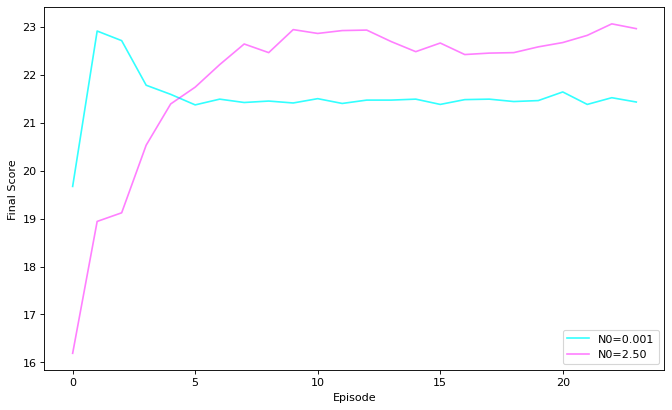

In [95]:
s1 = exp_lfa_n00.scores[:num_eps]
s2 = exp_lfa_n25.scores[:num_eps]
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
aux_plots.plot_2scores(s1_avg100, s2_avg100, "N0=0.001", "N0=2.50")

After running the experiment with 2500 we already can see the convergence for the model. Analyzing the results based on the mean for the 100 last scores in each run, we can see that it passes the baseline, but not by much, the chicken learns a similar strategy as the baseline that is to go forward and not to worry about the collisions. We can observe that the linear model is too simple and it underfits the problem.


In this second experiment we changed N0 to 0.001, and gave 2500 iterations. We can see that at first it rises very fast to the peak mean score of about 23, but as the weights keep being influenced to go forward we see that the weights explode to go only forward, going back to a mean score of 21.


### Scores Sarsa LSA with and without optimizer


In this third experiment we used an optimization algorithm to change alpha over time and used a similar strategy as the l2 regularization. The Adam optimization algorithm is an algorithm that update alpha as the experiment runs, so in each iteration we update alpha as follows:

```
self.m = self.beta_1 * self.m + (1 - self.beta_1) * g
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.power(g, 2)
        m_hat = self.m / (1 - np.power(self.beta_1, t))
        v_hat = self.v / (1 - np.power(self.beta_2, t))
        return self.alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)
```

Where m and v are first and second moment estimators.

Inspired by the l2 regularization we also tried to subtract lambda*Weights in the weights update, where lambda is a hyperparameter.



<AxesSubplot:xlabel='Episode', ylabel='Final Score'>

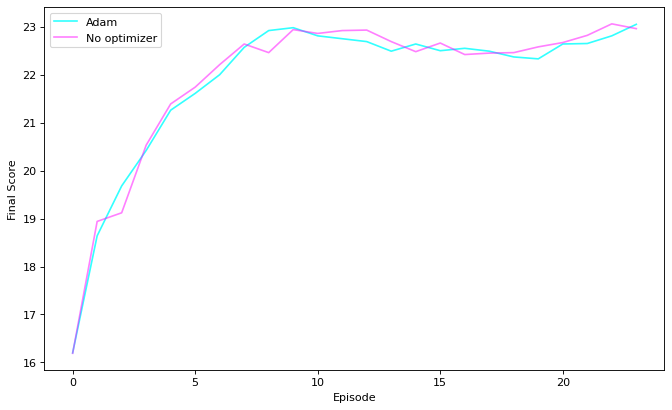

In [96]:
s1 = exp_adam_n25.scores[:num_eps]
s2 = exp_lfa_n25.scores[:num_eps]
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
aux_plots.plot_2scores(s1_avg100, s2_avg100, "Adam", "No optimizer")

In this experiment we ran many values for alpha, beta_1, beta_2 and lambda, and we concluded that Adam can speed up the convergence, but for these two ideas we coulnt see  an improvement of the solution. We ran 2500 iterations with alpha=0.001, beta1=0.9 and beta_2=0.99 and lambda=0.001, and N0 = 0.01, and we see the same conclusion as the previous experiment.

### Score Adam N0=0.01" vs "N0=2.50

We changed N0=2.5 and we compare if Adam works better with N0=0.01

<AxesSubplot:xlabel='Episode', ylabel='Final Score'>

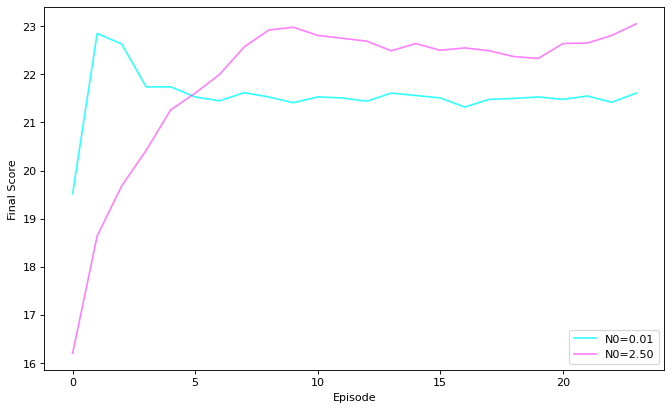

In [97]:
s1 = exp_adam.scores[:num_eps]
s2 = exp_adam_n25.scores[:num_eps]
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
aux_plots.plot_2scores(s1_avg100, s2_avg100, "N0=0.01", "N0=2.50")

### Reward Adam N0=0.01" vs "N0=2.50

<AxesSubplot:xlabel='Episode', ylabel='Final Reward'>

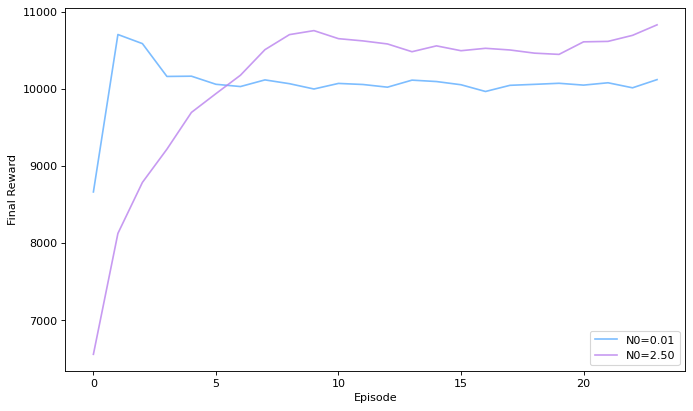

In [98]:
s1 = exp_adam.total_rewards[:num_eps]
s2 = exp_adam_n25.total_rewards[:num_eps]
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
    
aux_plots.plot_2rewards(s1_avg100, s2_avg100, "N0=0.01", "N0=2.50")

Unfortunately we see again results similar to the first experiment.


### Score Adam Reward=r1", "Reward=r3

<AxesSubplot:xlabel='Episode', ylabel='Final Score'>

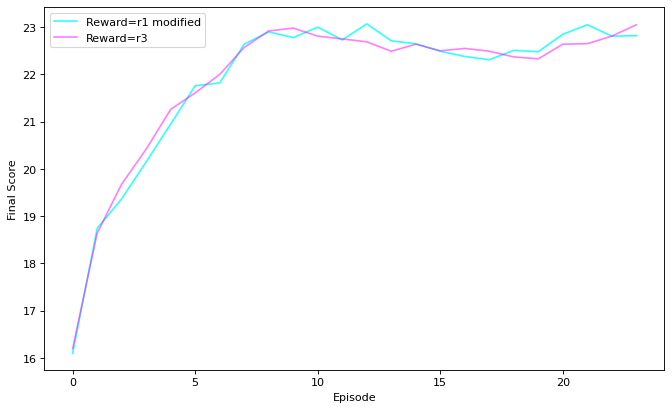

In [99]:
s1 = exp_adam_n25_r1.scores[:num_eps]
s2 = exp_adam_n25.scores[:num_eps]
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)


s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
aux_plots.plot_2scores(s1_avg100, s2_avg100, "Reward=r1 modified", "Reward=r3")

We changed the rewards to r1, in hopes that it could learn to avoid collisions, but it kept falling to very low scores since it was too scared and it was still most of the time. Changing only the reward when a collision happened to -0.5, then it got better but it just got as good as the other ones.


Sarsa LFA

This game requires a more complex model to make an approximation. The linear approximation for the three models underfitted, maybe with a more complex approximator or very well built features it could work better.

 Most models are influenced to learn to go forward, and cannot serve well to evaluate the state for this game. This is due to the low complexity of the model and the nature of the features and the fact that there are not many of them. 
Many other types of features were tested, such as the distance to the cars, reorganizing to get the distance to the next car and others, still the pure ram worked as good as the others. Another problem is that Sarsa can sometimes lose knowledge since it is not the exact gradient descent, as we saw in the experiments.

We can conclude that Sarsa with the linear function approximation performs way worse than Sarsa(lambda), as it reaches a mean of about 23 compared to our best result: 31.

In SarsaLFA we could see that a bigger N0 was beneficial to the solution, we believe that as the model get weights that learns to go only forward due to underfitting, to have some amount of randomness can sometimes avoid being hit by a car or start the crossing at another scenario of car positions.

The Adam optimizer was tested, and it can speed up the convergence sometimes, but mostly performs exactly as fast as the other models and reaches similar scores as well.

An advantage seen was that compared to Sarsa Lambda, this performs very fast, and for simpler cases this approximation can be of big advantage.

# Final Thoughts

## Computational cost

One of the biggest problems on this project was the computational cost of running an episode.

Since each run plays for 2 minutes and 16 seconds in the original game, there are quite a lot of frames that need to be computed for each episode.
Even though the frame-sync is deactivated in our environment, each time we execute on episode it takes about 2 seconds to compute it for Q-Learn and Monte Carlo, but it takes around 21s seconds for SARSA($\lambda$)! This means that in order to run 4k episodes, one must wait 23 hours. And since we want to experiment with 6 different values of $\lambda$, it would take about a week to compute this all using a single core processor.

The memory usage is fairly low compared to the time that it takes to run the algorithms, even with a decent amount of unique states in our problem.

## Optimality

Regarding the optimality of our solution, we were able to achive the state-of-the-art score (34.0) some times with the SARSA($\lambda$) algorithm, but on average we are closer to 31 points (which is also good, having said that our baseline was 21.8.
Q-Learning also showed really good results, achieving about 28 points on average.
On the other hand, Monte Carlo didn't perform well in our problem, achieving only 13 points on average.

## Regarding the Linear Function Approximators

According to the experiments realized with function approximation for Monte Carlo, Q Learning and Sarsa Lambda control algorithms, we achieved some meaningful results: 

* We were not able to improve the agents compared to the algorithms without function approximation. Some factors may have contributed to this, such as the simplicity of the linear approximator for a problem that, probably, have many nonlinear relationships between the environment variables. Also, the features that we created may not be good enough to provide meaningful information about the environment to the agents.

* The feature approximation of Monte Carlo said that we have to take a sample for our model in order to update the weight values. However, for our problems, this sample is the entire game, so each new generated sample follows a past policy that makes the convergence slow.

* Linear approximators can be faster than its original counterpart as we saw with SARSA, but it’s not always the case.

* To add randomness to underfitted models by using a bigger N0 can be beneficial to the solution.

* Each algorithm has its own specificities, that depends on how it works. For example, for the Monte Carlo approximator, using a less sparse feature vector contributed for better results. On the other hand, for the Q-Learning and Sarsa Lambda approximators, providing a bigger exploration capacity for the agent was very important to achieve better results.

* In all the experiments, the agents converged to a behavior similar to that of the baseline, learning that moving up the most part of the time is the best policy. However, as we saw from the algorithms without approximation, that is not the truth.

All in all, we were satisfied with what we achieved, being able to apply multiple tabular methods and experiment a lot on Reinforcement Learning.